In [130]:
import pandas as pd
import numpy as np
from warnings import filterwarnings
import sys
sys.path.append("../")
filterwarnings('ignore')
# matplotlib 中文问题
import matplotlib.pyplot as plt
from pathlib import Path
# 导入 pandarallel 并初始化
from pandarallel import pandarallel
from model.pre_process.utlis import aggregate_data

pandarallel.initialize(progress_bar=True)
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False  #用来正常显示负号

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


# 载入数据

## 读取prime原始数据

In [2]:
def read_tc_raw_data(filename: str) -> pd.DataFrame:
    df = pd.read_csv(filename,
                             dtype={"Item Number": "str", "Lot Number": "str", "Order Number": "str", "Load Number": "str",
                                    "To Load Number": "str", "Shipment": "str"})

    def col_rename(col_name: str):
        col_name = "_".join(col_name.strip().split(" "))
        return col_name.lower()

    df.columns = [col_rename(col) for col in df.columns]
    df['transaction_date'] = pd.to_datetime(df['transaction_date'])
    df['task_load_number'] = df['to_load_number'].fillna(df['load_number'])
    df['is_pick'] = df['to_load_number'].notnull()
    return df


data_path = Path(r"D:\Code\Python\sku_select_optimize\data\raw_data\2025 618")
file_list = list((data_path).rglob("*.csv"))
file_list.sort()
file_list

[WindowsPath('D:/Code/Python/sku_select_optimize/data/raw_data/2025 618/4567月Smart SKU带Overall Score.csv'),
 WindowsPath('D:/Code/Python/sku_select_optimize/data/raw_data/2025 618/4月/0401.csv'),
 WindowsPath('D:/Code/Python/sku_select_optimize/data/raw_data/2025 618/4月/0402.csv'),
 WindowsPath('D:/Code/Python/sku_select_optimize/data/raw_data/2025 618/4月/0403.csv'),
 WindowsPath('D:/Code/Python/sku_select_optimize/data/raw_data/2025 618/4月/0404.csv'),
 WindowsPath('D:/Code/Python/sku_select_optimize/data/raw_data/2025 618/4月/0405.csv'),
 WindowsPath('D:/Code/Python/sku_select_optimize/data/raw_data/2025 618/4月/0406.csv'),
 WindowsPath('D:/Code/Python/sku_select_optimize/data/raw_data/2025 618/4月/0407.csv'),
 WindowsPath('D:/Code/Python/sku_select_optimize/data/raw_data/2025 618/4月/0408.csv'),
 WindowsPath('D:/Code/Python/sku_select_optimize/data/raw_data/2025 618/4月/0409.csv'),
 WindowsPath('D:/Code/Python/sku_select_optimize/data/raw_data/2025 618/4月/0410.csv'),
 WindowsPath('D:/Code/

In [102]:
# 读取所有的文件并拼接
def read_tc_raw_datas_and_concat(file_list: list) -> pd.DataFrame:
    df_list = []
    for file in file_list:
        try:
            df = read_tc_raw_data(file)
            df_list.append(df)
        except Exception as e:
            pass
    df = pd.concat(df_list, ignore_index=True)
    return df


df = read_tc_raw_datas_and_concat(file_list)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7019913 entries, 0 to 7019912
Data columns (total 16 columns):
 #   Column            Dtype         
---  ------            -----         
 0   activity_code     object        
 1   operation_code    object        
 2   load_number       object        
 3   item_number       object        
 4   quantity          float64       
 5   from_area         object        
 6   from_location     object        
 7   to_area           object        
 8   to_location       object        
 9   user_id           object        
 10  transaction_date  datetime64[ns]
 11  order_number      object        
 12  to_load_number    object        
 13  task_load_number  object        
 14  is_pick           bool          
 15  lot_number        object        
dtypes: bool(1), datetime64[ns](1), float64(1), object(13)
memory usage: 810.1+ MB


## 读取sku主数据

In [4]:
sku_md_df = pd.read_excel(r'D:\Code\Python\sku_select_optimize\data\raw_data\SKU_MD_0509.xlsx', dtype={'material_num': 'str'})
sku_md_df.set_index('material_num', inplace=True)
sku_md_df

,product_name_en,product_name_cn,cs_barcode,sw_barcode,it_barcode,category_en,product_form_en,sales_unit,base_uom,length,...,height,height_unit,volume,volume_unit,gross_weight,weight_unit,buom_per_cs,suom_per_cs,su_per_cs,cs_per_pallet
material_num,,,,,,,,,,,,,,,,,,,,,
6273,PR-RG ORG 14X200G CEP,NaN,NaN,NaN,NaN,Snacks,Potato Chips,NaN,NaN,NaN,...,NaN,NaN,0.000,NaN,0.000,NaN,1.0,1.0,NaN,0
6715,PR-RG SCO 14X200GR CEP,NaN,NaN,NaN,NaN,Snacks,Potato Chips,NaN,NaN,NaN,...,NaN,NaN,0.000,NaN,0.000,NaN,1.0,1.0,NaN,0
7093,PR-RG SCO 14X200GR EUP,NaN,NaN,NaN,NaN,Snacks,Potato Chips,NaN,NaN,NaN,...,NaN,NaN,0.000,NaN,0.000,NaN,1.0,1.0,NaN,0
7139,PR-RG CHZ 14X200GR EUP,NaN,NaN,NaN,NaN,Snacks,Potato Chips,NaN,NaN,NaN,...,NaN,NaN,0.000,NaN,0.000,NaN,1.0,1.0,NaN,0
7145,PR-RG CHZ 14X200GR NOP,NaN,NaN,NaN,NaN,Snacks,Potato Chips,NaN,NaN,NaN,...,NaN,NaN,0.000,NaN,0.000,NaN,1.0,1.0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84995088,HESS CN BODYENVY 12/12Z VOLUMIZING,NaN,10381519019330,20381519019337,381519019333,Hair,NaN,CS,CS,28.448,...,22.53,CM,8.637,DM3,4.853,KG,1.0,1.0,1.596,0
84995987,OLAYREG PROX LTN SPF30 CANCELLED,NaN,NaN,NaN,NaN,Skin,Sunscreen,NaN,NaN,NaN,...,NaN,NaN,0.000,NaN,0.000,NaN,1.0,1.0,NaN,0
84996145,OLAY BW UM 6/23.6Z REM,NaN,10037000424311,NaN,37000424314,PCC,NaN,CS,CS,19.400,...,24.50,CM,8.841,DM3,4.400,KG,1.0,1.0,0.800,0


In [5]:
sku_buom_per_cs_s = sku_md_df.buom_per_cs
sku_buom_per_cs_dict = sku_buom_per_cs_s.to_dict()

# 数据预处理

## prime raw data处理

### 去除无用的activity_code

In [6]:
exclude_activity_code_list = ["Inventory Delete",
                              "Location Allocate to Empty Clear Automatic",
                              "Location Allocate to Empty Set Automatic",
                              "Location Override",
                              "Location Status Change",
                              "WQSO Change Priority",
                              "WQSO Change Assigned User",
                              "VC_CLS_TRK",
                              "Remaining ASN Removed",
                              "Master Receipt Close",
                              "Mass Update",
                              "Work Suspended",
                              "Lot Date Changed",
                              "Inventory Status Change"]

In [103]:
df = df[~df.activity_code.isin(exclude_activity_code_list)]
df

,activity_code,operation_code,load_number,item_number,quantity,from_area,from_location,to_area,to_location,user_id,transaction_date,order_number,to_load_number,task_load_number,is_pick,lot_number
0,Case Pick Movement,Transfer,00100370009098018327,80796219,4.0,RDT Devices,76D8A8,B2 shipping Staging,SS601,TC1171,2025-04-01 08:00:25,NaN,NaN,00100370009098018327,False,NaN
1,Pallet Pick,Resume List Pick,00100370009052837391,80790248,36.0,B2 ASRS storage location,3ASRS,B2 ASRS CP Virtual OUTFEED,3VASRSCP_S09,slDownload_28,2025-04-01 08:00:31,0067466340,00100370009098558557,00100370009098558557,True,NaN
2,Pallet Pick,List Pick,00100370009054763070,80721181,12.0,B2 ASRS storage location,3ASRS,B2 ASRS CP Virtual OUTFEED,3VASRSCP_S04,slDownload_28,2025-04-01 08:00:31,0067465429,00100370009054943427,00100370009054943427,True,NaN
3,Logical Movement,NaN,00100370009054943427,80721181,12.0,B2 ASRS CP Virtual OUTFEED,3VASRSCP_S04,B2 ASRS CP OUTFEED,3ASRSCP_S04,slDownload_28,2025-04-01 08:00:31,NaN,NaN,00100370009054943427,False,NaN
4,Pallet Pick,Resume List Pick,00100370009098549128,80701285,96.0,B2 ASRS storage location,3ASRS,B2 ASRS CP Virtual OUTFEED,3VASRSCP_S09,slDownload_28,2025-04-01 08:01:01,0067466340,00100370009098558557,00100370009098558557,True,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7019908,Undirected Full Inventory Move,NaN,00100370009098609105,80758056,77.0,B2 ASRS 2nd Floor OUTFEED 12（Include ASRS&Conv...,3ASRSOUT_W12,RDT Devices,76E030,TC1030,2025-07-01 07:58:39,NaN,NaN,00100370009098609105,False,NaN
7019909,Logical Movement,NaN,00100370009099036719,80804191,66.0,B1 lifter INFEED East,2ASRSIN,B2 ASRS 2nd Floor OUTFEED 12（Include ASRS&Conv...,3ASRSOUT_W12,slDownload_28,2025-07-01 07:59:26,NaN,NaN,00100370009099036719,False,NaN
7019910,Undirected Full Inventory Move,Undirected Load Transfer,00100370009098609105,80758056,77.0,RDT Devices,76E030,B2 shipping Staging,SS608,TC1030,2025-07-01 07:59:29,NaN,NaN,00100370009098609105,False,NaN
7019911,Identify,Undirected Identify,PERM-CRE-LOD-CNB9,80833615,39.0,Adjustments,PERM-CRE-LOC,Expected Receipts In DC01,4519296538~1812021,TC1197,2025-07-01 07:59:57,NaN,00100370009099175791,00100370009099175791,True,NaN


### 数据去重

#### 重复值分析

In [108]:
duplicate_columns = ['load_number', 'to_load_number', 'item_number', 'transaction_date', 'quantity', 'order_number']
temp_df = df.groupby(duplicate_columns).size().sort_values(ascending=False)
temp_df

load_number           to_load_number        item_number  transaction_date     quantity  order_number
00100370009098013179  00100370009098310636  80833453     2025-06-24 23:08:01  2.0       0067884492      2
L00000000000012019L1  00100370009017183143  80737822     2025-06-24 10:24:08  11.0      0067896283      2
00100370009098361409  00100370009098246331  80857536     2025-04-07 23:38:31  50.0      0067498185      2
L00000000000011756L1  00100370009039317830  80781266     2025-06-20 02:23:45  4.0       0067874208      2
00100370009099051736  00100370009099245340  80804689     2025-04-12 15:33:32  1.0       0067524501      2
                                                                                                       ..
T0100370009099347266  00100370009099347266  80742102     2025-05-16 02:42:01  20.0      0067708021      1
                                                         2025-05-16 02:42:02  28.0      0067708019      1
                                                   

In [105]:
temp_df.sum()

np.int64(366480)

In [101]:
temp_df[temp_df > 1]

Series([], dtype: int64)

In [109]:
df = df.drop_duplicates(subset=duplicate_columns)
df

,activity_code,operation_code,load_number,item_number,quantity,from_area,from_location,to_area,to_location,user_id,transaction_date,order_number,to_load_number,task_load_number,is_pick,lot_number
0,Case Pick Movement,Transfer,00100370009098018327,80796219,4.0,RDT Devices,76D8A8,B2 shipping Staging,SS601,TC1171,2025-04-01 08:00:25,NaN,NaN,00100370009098018327,False,NaN
1,Pallet Pick,Resume List Pick,00100370009052837391,80790248,36.0,B2 ASRS storage location,3ASRS,B2 ASRS CP Virtual OUTFEED,3VASRSCP_S09,slDownload_28,2025-04-01 08:00:31,0067466340,00100370009098558557,00100370009098558557,True,NaN
2,Pallet Pick,List Pick,00100370009054763070,80721181,12.0,B2 ASRS storage location,3ASRS,B2 ASRS CP Virtual OUTFEED,3VASRSCP_S04,slDownload_28,2025-04-01 08:00:31,0067465429,00100370009054943427,00100370009054943427,True,NaN
3,Logical Movement,NaN,00100370009054943427,80721181,12.0,B2 ASRS CP Virtual OUTFEED,3VASRSCP_S04,B2 ASRS CP OUTFEED,3ASRSCP_S04,slDownload_28,2025-04-01 08:00:31,NaN,NaN,00100370009054943427,False,NaN
4,Pallet Pick,Resume List Pick,00100370009098549128,80701285,96.0,B2 ASRS storage location,3ASRS,B2 ASRS CP Virtual OUTFEED,3VASRSCP_S09,slDownload_28,2025-04-01 08:01:01,0067466340,00100370009098558557,00100370009098558557,True,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7019908,Undirected Full Inventory Move,NaN,00100370009098609105,80758056,77.0,B2 ASRS 2nd Floor OUTFEED 12（Include ASRS&Conv...,3ASRSOUT_W12,RDT Devices,76E030,TC1030,2025-07-01 07:58:39,NaN,NaN,00100370009098609105,False,NaN
7019909,Logical Movement,NaN,00100370009099036719,80804191,66.0,B1 lifter INFEED East,2ASRSIN,B2 ASRS 2nd Floor OUTFEED 12（Include ASRS&Conv...,3ASRSOUT_W12,slDownload_28,2025-07-01 07:59:26,NaN,NaN,00100370009099036719,False,NaN
7019910,Undirected Full Inventory Move,Undirected Load Transfer,00100370009098609105,80758056,77.0,RDT Devices,76E030,B2 shipping Staging,SS608,TC1030,2025-07-01 07:59:29,NaN,NaN,00100370009098609105,False,NaN
7019911,Identify,Undirected Identify,PERM-CRE-LOD-CNB9,80833615,39.0,Adjustments,PERM-CRE-LOC,Expected Receipts In DC01,4519296538~1812021,TC1197,2025-07-01 07:59:57,NaN,00100370009099175791,00100370009099175791,True,NaN


### 计算qty_in_cs

In [110]:
df['qty_in_cs'] = df['quantity'] * df['item_number'].map(sku_buom_per_cs_dict)
# 当qtt_in_cs为null时，赋值为quantity
df['qty_in_cs'] = df['qty_in_cs'].fillna(df['quantity'])
df.qty_in_cs.info()

<class 'pandas.core.series.Series'>
Index: 5518566 entries, 0 to 7019912
Series name: qty_in_cs
Non-Null Count    Dtype  
--------------    -----  
5218895 non-null  float64
dtypes: float64(1)
memory usage: 84.2 MB


In [111]:
df.qty_in_cs.describe()

count    5.218895e+06
mean     2.162574e+04
std      1.111471e+06
min      0.000000e+00
25%      5.000000e+00
50%      3.200000e+01
75%      7.000000e+01
max      5.535360e+08
Name: qty_in_cs, dtype: float64

In [14]:
df[df.qty_in_cs.apply(lambda x: x % 1 != 0)]

,activity_code,operation_code,load_number,item_number,quantity,from_area,from_location,to_area,to_location,user_id,transaction_date,order_number,to_load_number,task_load_number,is_pick,lot_number,qty_in_cs
49,Inventory Identifier Changed,NaN,00100370009044607391,NaN,NaN,NaN,NaN,NaN,NaN,TC1171,2025-04-01 08:04:20,NaN,00100370009054977385,00100370009054977385,True,NaN,NaN
303,Inventory Identifier Changed,NaN,00100370009099105729,NaN,NaN,NaN,NaN,NaN,NaN,UNKNOWN,2025-04-01 08:09:02,NaN,00100000010035764232,00100000010035764232,True,NaN,NaN
304,Inventory Identifier Changed,NaN,00100370009098590243,NaN,NaN,NaN,NaN,NaN,NaN,UNKNOWN,2025-04-01 08:09:02,NaN,00100000010035764201,00100000010035764201,True,NaN,NaN
305,Inventory Identifier Changed,NaN,00100370009098680715,NaN,NaN,NaN,NaN,NaN,NaN,UNKNOWN,2025-04-01 08:09:02,NaN,00100000010035764256,00100000010035764256,True,NaN,NaN
306,Inventory Identifier Changed,NaN,00100370009099128018,NaN,NaN,NaN,NaN,NaN,NaN,UNKNOWN,2025-04-01 08:09:02,NaN,00100000010035764270,00100000010035764270,True,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7019030,Inventory Identifier Changed,NaN,00100370009039268293,NaN,NaN,NaN,NaN,NaN,NaN,TC1151,2025-07-01 07:25:28,NaN,00100370009098471344,00100370009098471344,True,NaN,NaN
7019067,Inventory Identifier Changed,NaN,00100370009098846227,NaN,NaN,NaN,NaN,NaN,NaN,TC430,2025-07-01 07:26:24,NaN,00100370009099257015,00100370009099257015,True,NaN,NaN
7019239,Inventory Identifier Changed,NaN,00100000010038312775,NaN,NaN,NaN,NaN,NaN,NaN,UNKNOWN,2025-07-01 07:30:01,NaN,00100000010038314885,00100000010038314885,True,NaN,NaN
7019240,Inventory Identifier Changed,NaN,00100000010038312782,NaN,NaN,NaN,NaN,NaN,NaN,UNKNOWN,2025-07-01 07:30:01,NaN,00100000010038314892,00100000010038314892,True,NaN,NaN


In [112]:
df = df[df.qty_in_cs <= 5000]
df

,activity_code,operation_code,load_number,item_number,quantity,from_area,from_location,to_area,to_location,user_id,transaction_date,order_number,to_load_number,task_load_number,is_pick,lot_number,qty_in_cs
0,Case Pick Movement,Transfer,00100370009098018327,80796219,4.0,RDT Devices,76D8A8,B2 shipping Staging,SS601,TC1171,2025-04-01 08:00:25,NaN,NaN,00100370009098018327,False,NaN,4.0
1,Pallet Pick,Resume List Pick,00100370009052837391,80790248,36.0,B2 ASRS storage location,3ASRS,B2 ASRS CP Virtual OUTFEED,3VASRSCP_S09,slDownload_28,2025-04-01 08:00:31,0067466340,00100370009098558557,00100370009098558557,True,NaN,432.0
2,Pallet Pick,List Pick,00100370009054763070,80721181,12.0,B2 ASRS storage location,3ASRS,B2 ASRS CP Virtual OUTFEED,3VASRSCP_S04,slDownload_28,2025-04-01 08:00:31,0067465429,00100370009054943427,00100370009054943427,True,NaN,12.0
3,Logical Movement,NaN,00100370009054943427,80721181,12.0,B2 ASRS CP Virtual OUTFEED,3VASRSCP_S04,B2 ASRS CP OUTFEED,3ASRSCP_S04,slDownload_28,2025-04-01 08:00:31,NaN,NaN,00100370009054943427,False,NaN,12.0
4,Pallet Pick,Resume List Pick,00100370009098549128,80701285,96.0,B2 ASRS storage location,3ASRS,B2 ASRS CP Virtual OUTFEED,3VASRSCP_S09,slDownload_28,2025-04-01 08:01:01,0067466340,00100370009098558557,00100370009098558557,True,NaN,4608.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7019908,Undirected Full Inventory Move,NaN,00100370009098609105,80758056,77.0,B2 ASRS 2nd Floor OUTFEED 12（Include ASRS&Conv...,3ASRSOUT_W12,RDT Devices,76E030,TC1030,2025-07-01 07:58:39,NaN,NaN,00100370009098609105,False,NaN,77.0
7019909,Logical Movement,NaN,00100370009099036719,80804191,66.0,B1 lifter INFEED East,2ASRSIN,B2 ASRS 2nd Floor OUTFEED 12（Include ASRS&Conv...,3ASRSOUT_W12,slDownload_28,2025-07-01 07:59:26,NaN,NaN,00100370009099036719,False,NaN,66.0
7019910,Undirected Full Inventory Move,Undirected Load Transfer,00100370009098609105,80758056,77.0,RDT Devices,76E030,B2 shipping Staging,SS608,TC1030,2025-07-01 07:59:29,NaN,NaN,00100370009098609105,False,NaN,77.0
7019911,Identify,Undirected Identify,PERM-CRE-LOD-CNB9,80833615,39.0,Adjustments,PERM-CRE-LOC,Expected Receipts In DC01,4519296538~1812021,TC1197,2025-07-01 07:59:57,NaN,00100370009099175791,00100370009099175791,True,NaN,39.0


In [113]:
df.qty_in_cs.describe()

count    5.114310e+06
mean     8.637330e+01
std      3.356847e+02
min      0.000000e+00
25%      5.000000e+00
50%      3.000000e+01
75%      6.600000e+01
max      5.000000e+03
Name: qty_in_cs, dtype: float64

### 添加category_en列

In [15]:
df['category_en'] = df['item_number'].map(sku_md_df['category_en'])

# 散拣数据分析

In [16]:
df.activity_code.value_counts().index

Index(['Trailer load', 'Logical Movement', 'Undirected Full Inventory Move',
       'List Pick', 'Pallet Stage by Ship Id', 'Pallet Pick',
       'Engagement Process Change', 'Receiving',
       'Inventory Identifier Changed', 'Pallet Replenishment', 'Identify',
       'Case Pick Movement', 'Identify against Work Order',
       'System Directed Putaway', 'Inventory Ownership Change (3PL)',
       'Identify W/o Order', 'Order Line Changed', 'Mixed Pallet Move',
       'Pallet Pick Movement', 'Bulk Pick', 'Trailer Unload',
       'Undirected Full Inventory Move with Putaway', 'Piece Pick Movement',
       'Receive Staging', 'Undirected Partial Inventory Move',
       'Reverse Receipt', 'Inventory Found in Wrong Location', 'Cross Docking',
       'Unpick', 'Item Footprint UOM Creation', 'Inventory Attribute Change',
       'Cancel Pick', 'Item Footprint UOM Removal', 'Work Order Started',
       'Undirected Putaway', 'Count Back Discrepancy',
       'Undirected Case Transfer', 'LAYPCK',
 

In [17]:
# 模糊匹配方法
def fuzzy_match_str(columns: list, match_str: str) -> list:
    import re
    return [col for col in columns if re.search(match_str, col)]


def fuzzy_match_str_list(columns: list, match_str_list: list) -> list:
    import re
    return [col for col in columns if any(re.search(match_str, col) for match_str in match_str_list)]

In [18]:
list_pick_match_activity_code = [r'Case Replenishment.*']
list_pick_match_operation_code = [r'List Pick', 'Resume List Pick', 'Inventory Identifier Changed']
all_activity_codes = df.activity_code.value_counts().index
all_operation_codes = df.operation_code.value_counts().index
list_pick_activity_code = fuzzy_match_str_list(all_activity_codes, list_pick_match_activity_code)
list_pick_operation_code = fuzzy_match_str_list(all_operation_codes, list_pick_match_operation_code)

In [19]:
list_pick_df = df[df.activity_code.isin(list_pick_activity_code) | df.operation_code.isin(list_pick_operation_code)]

In [20]:
# 再次过滤
second_activity_code_filter_list = ['List Pick', 'Case Replenishment', 'Logical Movement',
                                    'Inventory Identifier Changed']
list_pick_df = list_pick_df[list_pick_df.activity_code.isin(second_activity_code_filter_list)]

In [116]:
list_pick_df

,activity_code,operation_code,load_number,item_number,quantity,from_area,from_location,to_area,to_location,user_id,transaction_date,order_number,to_load_number,task_load_number,is_pick,lot_number,qty_in_cs,category_en
21,List Pick,List Pick,L00000000000021553L1,80745943,5.0,Case picking in DC02 for fast moving,21553L1,RDT Devices,77D7CC,TC1008,2025-04-01 08:03:15,0067446694,00100370009048944089,00100370009048944089,True,NaN,5.0,Hair
38,List Pick,List Pick,L00000000000021711L1,82284999,5.0,Case picking in DC02 for fast moving,21711L1,RDT Devices,77D7CC,TC1008,2025-04-01 08:04:05,0067462429,00100370009048944089,00100370009048944089,True,NaN,5.0,Fabric
42,List Pick,List Pick,L00000000000021707L1,80781269,2.0,Case picking in DC02 for fast moving,21707L1,RDT Devices,77D7CC,TC1008,2025-04-01 08:04:13,0067467406,00100370009048944089,00100370009048944089,True,NaN,2.0,PCC
43,List Pick,List Pick,L00000000000021707L1,80781269,4.0,Case picking in DC02 for fast moving,21707L1,RDT Devices,77D7CC,TC1008,2025-04-01 08:04:13,0067446694,00100370009048944089,00100370009048944089,True,NaN,4.0,PCC
91,List Pick,List Pick,L00000000000021901L1,80753072,2.0,Case picking in DC02 for fast moving,21901L1,RDT Devices,77D7CC,TC1008,2025-04-01 08:04:53,0067446694,00100370009048944089,00100370009048944089,True,NaN,2.0,PCC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7019863,List Pick,Resume List Pick,00100370009039655314,80691635,1.0,RDT Devices,77CE38,Shipping staging in DC02,SS210A,TC1196,2025-07-01 07:52:44,NaN,NaN,00100370009039655314,False,NaN,1.0,Fabric
7019864,List Pick,Resume List Pick,00100370009039655314,80710891,4.0,RDT Devices,77CE38,Shipping staging in DC02,SS210A,TC1196,2025-07-01 07:52:44,NaN,NaN,00100370009039655314,False,NaN,4.0,Fabric
7019865,List Pick,Resume List Pick,00100370009039655314,80824169,2.0,RDT Devices,77CE38,Shipping staging in DC02,SS210A,TC1196,2025-07-01 07:52:44,NaN,NaN,00100370009039655314,False,NaN,2.0,PCC
7019866,List Pick,Resume List Pick,00100370009039655314,80736041,5.0,RDT Devices,77CE38,Shipping staging in DC02,SS210A,TC1196,2025-07-01 07:52:44,NaN,NaN,00100370009039655314,False,NaN,5.0,PCC


## 按 user_id 分组标识不同工作日

In [154]:
# 按 user_id 和 transaction_date 排序
sorted_df = list_pick_df.sort_values(by=['user_id', 'transaction_date'])


def label_workdays(group):
    # 计算相邻记录的时间差
    time_diff = group['transaction_date'] - group['transaction_date'].shift(1)
    # 判断时间差是否大于 8 小时，若为第一行则默认标记为新工作日
    new_workday = (time_diff > pd.Timedelta(hours=2)) | group['transaction_date'].isnull()
    new_workday.iloc[0] = True

    # 为每个工作日分配唯一编号
    workday_id = new_workday.cumsum()

    # 确定每个工作日的开始时间
    workday_start = group['transaction_date'].groupby(workday_id).transform('min')
    # 确定每个工作日的结束时间
    workday_end = group['transaction_date'].groupby(workday_id).transform('max')

    group['workday_id'] = workday_id
    group['workday_start'] = workday_start
    group['workday_end'] = workday_end
    return group

# 按 user_id 分组处理
labeled_df = sorted_df.groupby('user_id', group_keys=False).apply(label_workdays)
labeled_df

,activity_code,operation_code,load_number,item_number,quantity,from_area,from_location,to_area,to_location,user_id,...,order_number,to_load_number,task_load_number,is_pick,lot_number,qty_in_cs,category_en,workday_id,workday_start,workday_end
1504380,List Pick,List Pick,L00000000000021715L1,80782788,7.0,Case picking in DC02 for fast moving,21715L1,RDT Devices,76E200,TC003,...,0067570644,00100370009098383319,00100370009098383319,True,NaN,7.0,PCC,1,2025-04-22 12:32:50,2025-04-22 18:19:27
1504535,List Pick,List Pick,L00000000000011756L1,80781266,13.0,Case picking in DC01 for fast moving,11756L1,RDT Devices,76E200,TC003,...,0067570644,00100370009098383319,00100370009098383319,True,NaN,13.0,PCC,1,2025-04-22 12:32:50,2025-04-22 18:19:27
1504735,List Pick,List Pick,00100370009098383319,80782788,7.0,RDT Devices,76E200,Shipping staging in DC01,SS112,TC003,...,NaN,NaN,00100370009098383319,False,NaN,7.0,PCC,1,2025-04-22 12:32:50,2025-04-22 18:19:27
1504736,List Pick,List Pick,00100370009098383319,80781266,13.0,RDT Devices,76E200,Shipping staging in DC01,SS112,TC003,...,NaN,NaN,00100370009098383319,False,NaN,13.0,PCC,1,2025-04-22 12:32:50,2025-04-22 18:19:27
1508914,List Pick,List Pick,L00000000000012215L1,80781281,5.0,Case picking in DC01 for slow moving,12215L1,RDT Devices,76E200,TC003,...,0067568878,00100370009099330619,00100370009099330619,True,NaN,5.0,PCC,1,2025-04-22 12:32:50,2025-04-22 18:19:27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6879944,List Pick,List Pick,00100370009016962022,80814061,4.0,RDT Devices,77D6A8,Shipping staging in DC01,SS116A,TC823,...,NaN,NaN,00100370009016962022,False,NaN,4.0,Hair,68,2025-06-27 18:57:09,2025-06-28 07:44:51
6913703,List Pick,List Pick,L00000000000021755L1,80710891,50.0,Case picking in DC02 for fast moving,21755L1,RDT Devices,77D6A8,TC823,...,0067914158,00100370009016961674,00100370009016961674,True,NaN,50.0,Fabric,69,2025-06-28 18:56:43,2025-06-28 19:35:44
6916267,List Pick,List Pick,L00000000000011658L1,80853518,72.0,Case picking in DC01 for fast moving,11658L1,RDT Devices,77D6A8,TC823,...,0067921469,00100370009016961674,00100370009016961674,True,NaN,72.0,Hair,69,2025-06-28 18:56:43,2025-06-28 19:35:44
6916271,List Pick,List Pick,00100370009016961674,80710891,50.0,RDT Devices,77D6A8,Shipping staging in DC02,SS204,TC823,...,NaN,NaN,00100370009016961674,False,NaN,50.0,Fabric,69,2025-06-28 18:56:43,2025-06-28 19:35:44


In [155]:
labeled_df['workday_time_diff'] = labeled_df['workday_end'] - labeled_df['workday_start']

In [156]:
labeled_df[labeled_df.workday_time_diff < pd.Timedelta(hours=2)]

,activity_code,operation_code,load_number,item_number,quantity,from_area,from_location,to_area,to_location,user_id,...,to_load_number,task_load_number,is_pick,lot_number,qty_in_cs,category_en,workday_id,workday_start,workday_end,workday_time_diff
1606613,List Pick,List Pick,L00000000000011804L1,80687474,1.0,Case picking in DC01 for fast moving,11804L1,RDT Devices,76DDC8,TC003,...,00100370009098502932,00100370009098502932,True,NaN,1.0,Fabric,2,2025-04-23 12:02:46,2025-04-23 13:00:07,0 days 00:57:21
1606696,List Pick,List Pick,00100370009098502932,80687474,1.0,RDT Devices,76DDC8,Shipping staging in DC02,SS217,TC003,...,NaN,00100370009098502932,False,NaN,1.0,Fabric,2,2025-04-23 12:02:46,2025-04-23 13:00:07,0 days 00:57:21
1612481,List Pick,List Pick,L00000000000011647L1,80813635,10.0,Case picking in DC01 for slow moving,11647L1,RDT Devices,76DDC8,TC003,...,00100370009098741584,00100370009098741584,True,NaN,10.0,Hair,2,2025-04-23 12:02:46,2025-04-23 13:00:07,0 days 00:57:21
1612566,List Pick,List Pick,00100370009098741584,80813635,10.0,RDT Devices,76DDC8,Shipping staging in DC02,SS225,TC003,...,NaN,00100370009098741584,False,NaN,10.0,Hair,2,2025-04-23 12:02:46,2025-04-23 13:00:07,0 days 00:57:21
1612680,List Pick,List Pick,L00000000000011404L1,80748849,1.0,Case picking in DC01 for fast moving,11404L1,RDT Devices,76DDC8,TC003,...,00100370009098658011,00100370009098658011,True,NaN,1.0,Hair,2,2025-04-23 12:02:46,2025-04-23 13:00:07,0 days 00:57:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6152279,List Pick,List Pick,00100370009017188926,80784126,96.0,RDT Devices,77D6A8,Shipping staging in DC01,SS109,TC823,...,NaN,00100370009017188926,False,NaN,96.0,Hair,57,2025-06-18 08:02:51,2025-06-18 09:41:23,0 days 01:38:32
6913703,List Pick,List Pick,L00000000000021755L1,80710891,50.0,Case picking in DC02 for fast moving,21755L1,RDT Devices,77D6A8,TC823,...,00100370009016961674,00100370009016961674,True,NaN,50.0,Fabric,69,2025-06-28 18:56:43,2025-06-28 19:35:44,0 days 00:39:01
6916267,List Pick,List Pick,L00000000000011658L1,80853518,72.0,Case picking in DC01 for fast moving,11658L1,RDT Devices,77D6A8,TC823,...,00100370009016961674,00100370009016961674,True,NaN,72.0,Hair,69,2025-06-28 18:56:43,2025-06-28 19:35:44,0 days 00:39:01
6916271,List Pick,List Pick,00100370009016961674,80710891,50.0,RDT Devices,77D6A8,Shipping staging in DC02,SS204,TC823,...,NaN,00100370009016961674,False,NaN,50.0,Fabric,69,2025-06-28 18:56:43,2025-06-28 19:35:44,0 days 00:39:01


In [158]:
labeled_df[labeled_df.workday_time_diff > pd.Timedelta(hours=24)]

,activity_code,operation_code,load_number,item_number,quantity,from_area,from_location,to_area,to_location,user_id,...,to_load_number,task_load_number,is_pick,lot_number,qty_in_cs,category_en,workday_id,workday_start,workday_end,workday_time_diff
2965409,List Pick,List Pick,L00000000000020733L1,82311870,24.0,Case picking in DC02 for fast moving,20733L1,RDT Devices,77D25C,TC509,...,00100370009048414483,00100370009048414483,True,NaN,24.0,Baby,9,2025-05-09 19:27:22,2025-05-11 18:24:46,1 days 22:57:24
2965646,List Pick,List Pick,L00000000000020744L1,82311869,1.0,Case picking in DC02 for fast moving,20744L1,RDT Devices,77D25C,TC509,...,00100370009048414483,00100370009048414483,True,NaN,1.0,Baby,9,2025-05-09 19:27:22,2025-05-11 18:24:46,1 days 22:57:24
2967044,List Pick,List Pick,L00000000000020822L1,80754353,5.0,Case picking in DC02 for fast moving,20822L1,RDT Devices,77D25C,TC509,...,00100370009048414483,00100370009048414483,True,NaN,5.0,Baby,9,2025-05-09 19:27:22,2025-05-11 18:24:46,1 days 22:57:24
2967255,List Pick,List Pick,00100370009048414483,82311870,24.0,RDT Devices,77D25C,PD area in B1 to B2 DC02,2B1B2HF,TC509,...,NaN,00100370009048414483,False,NaN,24.0,Baby,9,2025-05-09 19:27:22,2025-05-11 18:24:46,1 days 22:57:24
2967256,List Pick,List Pick,00100370009048414483,82311869,1.0,RDT Devices,77D25C,PD area in B1 to B2 DC02,2B1B2HF,TC509,...,NaN,00100370009048414483,False,NaN,1.0,Baby,9,2025-05-09 19:27:22,2025-05-11 18:24:46,1 days 22:57:24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3975656,List Pick,List Pick,00100370009048251873,80807105,6.0,RDT Devices,77CF84,Shipping staging in DC01,SS119B,TC509,...,NaN,00100370009048251873,False,NaN,6.0,Oral,14,2025-05-17 08:15:01,2025-05-18 18:48:42,1 days 10:33:41
3975657,List Pick,List Pick,00100370009048251873,80735223,1.0,RDT Devices,77CF84,Shipping staging in DC01,SS119B,TC509,...,NaN,00100370009048251873,False,NaN,1.0,Hair,14,2025-05-17 08:15:01,2025-05-18 18:48:42,1 days 10:33:41
3975658,List Pick,List Pick,00100370009048251873,80833394,2.0,RDT Devices,77CF84,Shipping staging in DC01,SS119B,TC509,...,NaN,00100370009048251873,False,NaN,2.0,Oral,14,2025-05-17 08:15:01,2025-05-18 18:48:42,1 days 10:33:41
3975659,List Pick,List Pick,00100370009048251873,80855070,12.0,RDT Devices,77CF84,Shipping staging in DC01,SS119B,TC509,...,NaN,00100370009048251873,False,NaN,12.0,Oral,14,2025-05-17 08:15:01,2025-05-18 18:48:42,1 days 10:33:41


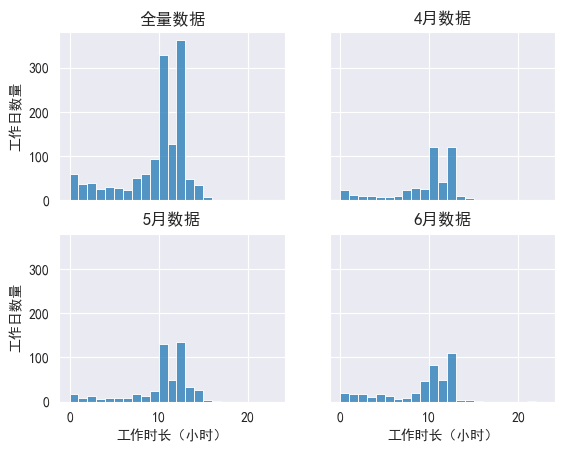

In [138]:
sorted_df = labeled_df.sort_values(by=['user_id', 'workday_id', 'transaction_date'])

# 导入 seaborn 和 matplotlib 库
import seaborn as sns
import matplotlib.pyplot as plt


def plot_workday_duration(user_data_df, ax=None, title=None):
    # 筛选指定 user_id 的数据
    # 将工作时长转换为小时
    user_data_df = user_data_df.groupby(['user_id', 'workday_id'])['workday_time_diff'].first()
    user_data_df = user_data_df.dt.total_seconds() / 3600

    # 设置图片清晰度
    # plt.rcParams['figure.dpi'] = 300
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()
    # 使用 seaborn 绘制直方图
    sns.histplot(user_data_df, kde=False, bins=range(0, 24), ax=ax)
    title = title or user_data_df.name
    ax.set_title(f"{title}")
    ax.set_xlabel("工作时长（小时）")
    ax.set_ylabel("工作日数量")


fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
axs = np.array(axs).flatten()
plot_workday_duration(labeled_df, axs[0], '全量数据');
plot_workday_duration(labeled_df[labeled_df.transaction_date.dt.month == 4], axs[1], '4月数据');
plot_workday_duration(labeled_df[labeled_df.transaction_date.dt.month == 5], axs[2], '5月数据');
plot_workday_duration(labeled_df[labeled_df.transaction_date.dt.month == 6], axs[3], '6月数据');
plt.show()


Text(0, 0.5, '工作日数量')

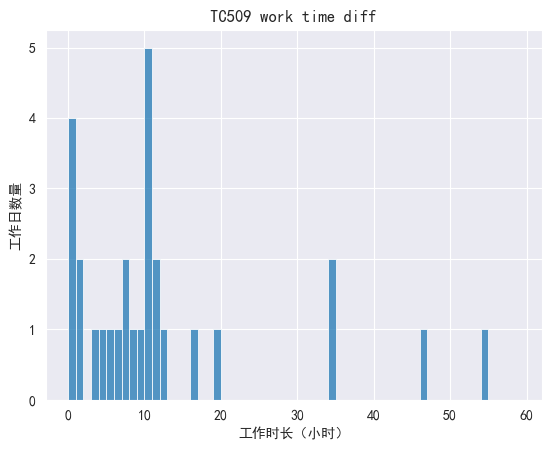

In [160]:
# 筛选指定 user_id 的数据
# 将工作时长转换为小时
user_data_df = labeled_df.query("user_id == 'TC509'").groupby(['user_id', 'workday_id'])['workday_time_diff'].first()
user_data_df = user_data_df.dt.total_seconds() / 3600

# 设置图片清晰度
# plt.rcParams['figure.dpi'] = 300
fig, ax = plt.subplots()
# 使用 seaborn 绘制直方图
sns.histplot(user_data_df, kde=False, bins=range(0, 60), ax=ax)
title = user_data_df.name
ax.set_title(f"TC509 work time diff")
ax.set_xlabel("工作时长（小时）")
ax.set_ylabel("工作日数量")

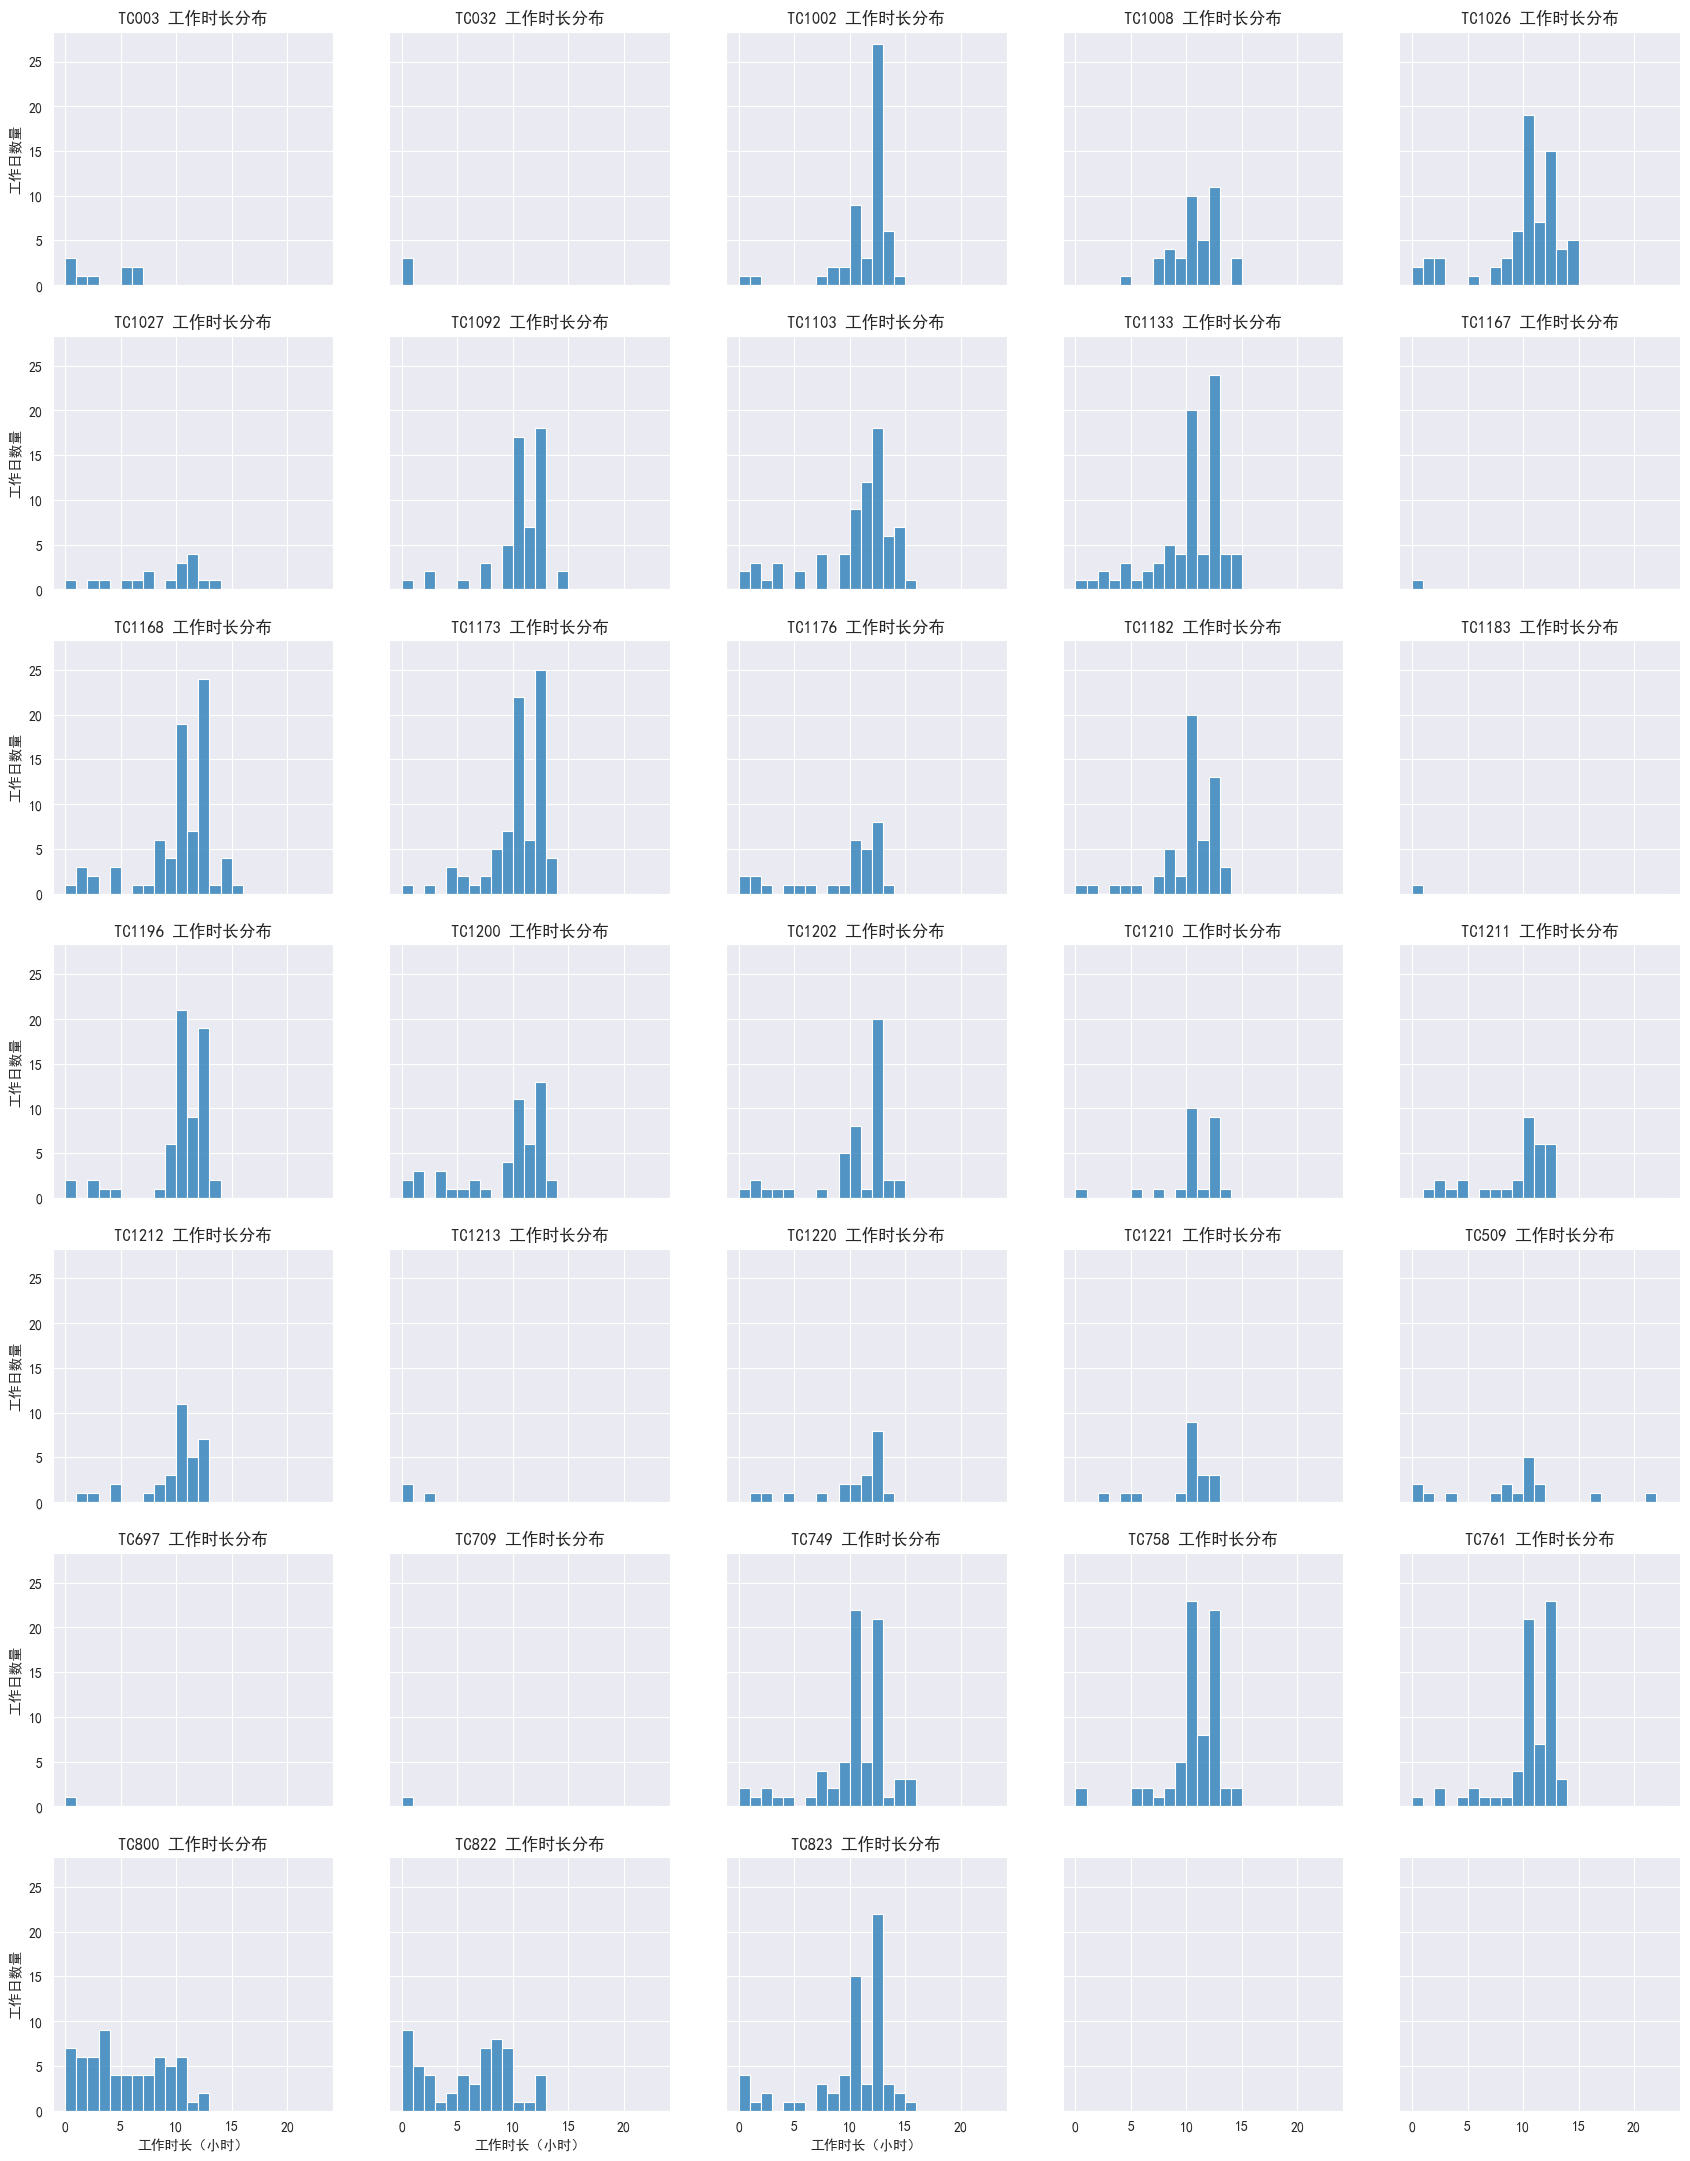

In [139]:
# 绘制不同员工工作时长
user_nums = len(labeled_df['user_id'].unique())
fig, axs = plt.subplots(nrows=7, ncols=5, sharex=True, sharey=True, figsize=(21, 27))
axs = np.array(axs).flatten()
for i, user_id in enumerate(labeled_df['user_id'].unique()):
    user_data = labeled_df[labeled_df['user_id'] == user_id]
    plot_workday_duration(user_data, axs[i], f"{user_id} 工作时长分布")
plt.show()

## 划分任务单元

In [31]:
sorted_df = labeled_df.sort_values(by=['user_id', 'workday_id', 'transaction_date'])

def check_to_load_number_reuse(group):
    # 判断 to_load_number 是否发生变化
    to_load_number_changed = group['to_load_number'] != group['to_load_number'].shift(1)
    to_load_number_changed.iloc[0] = True

    # 为每个 to_load_number 操作段分配唯一编号
    to_load_number_seg_id = to_load_number_changed.cumsum()

    # 计算每个 to_load_number 操作段的开始和结束时间
    start_time = group['transaction_date'].groupby(to_load_number_seg_id).transform('min')
    end_time = group['transaction_date'].groupby(to_load_number_seg_id).transform('max')

    # 检查是否存在 to_load_number 复用情况
    reuse_check = to_load_number_seg_id.groupby(group['to_load_number']).transform('nunique') > 1

    group['to_load_number_seg_id'] = to_load_number_seg_id
    group['to_load_number_start_time'] = start_time
    group['to_load_number_end_time'] = end_time
    group['to_load_number_reused'] = reuse_check

    return group


# 按 user_id 和 workday_id 分组处理
result_df = sorted_df.groupby(['user_id']).apply(check_to_load_number_reuse)

# 筛选出存在 to_load_number 复用的记录
reused_records = result_df[result_df['to_load_number_reused']]
reused_records.index = reused_records.index.droplevel(0)

reused_records

,activity_code,operation_code,load_number,item_number,quantity,from_area,from_location,to_area,to_location,user_id,...,qty_in_cs,category_en,workday_id,workday_start,workday_end,workday_time_diff,to_load_number_seg_id,to_load_number_start_time,to_load_number_end_time,to_load_number_reused
1511727,List Pick,List Pick,L00000000000025008L1,80744720,2.0,Case picking in DC02 for slow moving,25008L1,RDT Devices,76E200,TC003,...,2.0,Hair,1,2025-04-22 12:32:50,2025-04-22 18:19:27,0 days 05:46:37,13,2025-04-22 13:50:39,2025-04-22 13:50:39,True
1511728,List Pick,List Pick,L00000000000025008L1,80744720,3.0,Case picking in DC02 for slow moving,25008L1,RDT Devices,76E200,TC003,...,3.0,Hair,1,2025-04-22 12:32:50,2025-04-22 18:19:27,0 days 05:46:37,13,2025-04-22 13:50:39,2025-04-22 13:50:39,True
1511770,List Pick,List Pick,L00000000000026012L1,80833453,16.0,Case picking in DC02 for slow moving,26012L1,RDT Devices,76E200,TC003,...,16.0,Hair,1,2025-04-22 12:32:50,2025-04-22 18:19:27,0 days 05:46:37,16,2025-04-22 13:51:23,2025-04-22 13:51:23,True
2746911,List Pick,List Pick,L00000000000022101L1,80740683,6.0,Case picking in DC02 for fast moving,22101L1,RDT Devices,77DB18,TC003,...,6.0,Hair,3,2025-05-07 23:42:05,2025-05-08 05:12:00,0 days 05:29:55,39,2025-05-07 23:43:34,2025-05-07 23:46:33,True
2747042,List Pick,List Pick,L00000000000011410L1,80820168,1.0,Case picking in DC01 for fast moving,11410L1,RDT Devices,77DB18,TC003,...,1.0,Hair,3,2025-05-07 23:42:05,2025-05-08 05:12:00,0 days 05:29:55,39,2025-05-07 23:43:34,2025-05-07 23:46:33,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6725743,List Pick,List Pick,L00000000000021522L1,80813640,10.0,Case picking in DC02 for fast moving,21522L1,RDT Devices,77D6A8,TC823,...,10.0,Hair,61,2025-06-25 18:49:39,2025-06-26 07:46:36,0 days 12:56:57,23231,2025-06-26 03:57:06,2025-06-26 03:57:38,True
6726834,List Pick,List Pick,L00000000000021556L1,80815643,50.0,Case picking in DC02 for fast moving,21556L1,RDT Devices,77D6A8,TC823,...,50.0,Hair,61,2025-06-25 18:49:39,2025-06-26 07:46:36,0 days 12:56:57,23249,2025-06-26 04:29:57,2025-06-26 04:33:08,True
6726852,List Pick,List Pick,L00000000000021607L1,80820490,5.0,Case picking in DC02 for fast moving,21607L1,RDT Devices,77D6A8,TC823,...,5.0,Hair,61,2025-06-25 18:49:39,2025-06-26 07:46:36,0 days 12:56:57,23249,2025-06-26 04:29:57,2025-06-26 04:33:08,True
6726878,List Pick,List Pick,L00000000000021624L1,80814089,20.0,Case picking in DC02 for fast moving,21624L1,RDT Devices,77D6A8,TC823,...,20.0,Hair,61,2025-06-25 18:49:39,2025-06-26 07:46:36,0 days 12:56:57,23249,2025-06-26 04:29:57,2025-06-26 04:33:08,True


In [32]:
def assign_task_id(group_df: pd.DataFrame) -> pd.DataFrame:
    # 为每个 to_load_number 操作段分配唯一编号
    sorted_df = group_df.sort_values(by=['task_load_number', 'transaction_date'])
    # is_pick发生变化，如果是从0到1则说明是新任务
    is_pick_changed = sorted_df['is_pick'] - sorted_df['is_pick'].shift(1)
    is_pick_changed.iloc[0] = 0
    is_pick_changed[is_pick_changed == -1] = 0
    is_pick_changed = is_pick_changed.astype(bool)
    task_load_number_is_changed = sorted_df['task_load_number'] != sorted_df['task_load_number'].shift(1)
    # 为每个 to_load_number 操作段分配唯一编号
    to_load_number_seg_id = is_pick_changed | task_load_number_is_changed
    sorted_df['task_id'] = to_load_number_seg_id.cumsum()
    return sorted_df

task_label_df = labeled_df.groupby(['user_id', 'workday_id'], as_index=False, group_keys=False).apply(assign_task_id)

In [33]:
# 标记任务是否是有效任务
def get_unique_task_start_time(group_df: pd.DataFrame):
    sorted_df = group_df.sort_values(by=['transaction_date'])
    return sorted_df['transaction_date'].iloc[0]


unique_df = task_label_df.groupby(['user_id', 'workday_id', 'task_id', 'task_load_number']).apply(
        get_unique_task_start_time)
unique_df.name = 'start_time'
unique_df = unique_df.reset_index()
unique_df = unique_df.sort_values(by=['start_time'])
unique_df['index'] = np.arange(len(unique_df)) + 1
unique_df['unique_label'] = unique_df.apply(
        lambda x: f"{x['user_id']}_{x['workday_id']}_{x['task_id']}_{x['task_load_number']}", axis=1)

unique_df

,user_id,workday_id,task_id,task_load_number,start_time,index,unique_label
3591,TC1008,1,94,00100370009048944089,2025-04-01 08:03:15,1,TC1008_1_94_00100370009048944089
27429,TC1173,1,65,00100370009048890997,2025-04-01 08:07:33,2,TC1173_1_65_00100370009048890997
27428,TC1173,1,64,00100370009048890980,2025-04-01 08:11:39,3,TC1173_1_64_00100370009048890980
61363,TC823,1,65,00100370009048922209,2025-04-01 08:11:55,4,TC823_1_65_00100370009048922209
32324,TC1182,1,43,00100370009048784203,2025-04-01 08:12:29,5,TC1182_1_43_00100370009048784203
...,...,...,...,...,...,...,...
19499,TC1103,72,2,00100370009039562537,2025-07-01 07:40:26,65733,TC1103_72_2_00100370009039562537
45254,TC1221,19,1,00100370009016961223,2025-07-01 07:44:10,65734,TC1221_19_1_00100370009016961223
46784,TC509,19,47,L000000000000000R964,2025-07-01 07:45:35,65735,TC509_19_47_L000000000000000R964
46785,TC509,19,48,L000000000000000R965,2025-07-01 07:47:00,65736,TC509_19_48_L000000000000000R965


In [34]:
unique_label_map_dict = unique_df.set_index('unique_label')['index'].to_dict()
unique_label_map_dict

{'TC1008_1_94_00100370009048944089': 1,
 'TC1173_1_65_00100370009048890997': 2,
 'TC1173_1_64_00100370009048890980': 3,
 'TC823_1_65_00100370009048922209': 4,
 'TC1182_1_43_00100370009048784203': 5,
 'TC1173_1_63_00100370009048890973': 6,
 'TC1008_1_93_00100370009048944072': 7,
 'TC822_1_58_00100370009048822646': 8,
 'TC1133_1_89_00100370009048772088': 9,
 'TC1008_1_92_00100370009048944065': 10,
 'TC822_1_57_00100370009048822639': 11,
 'TC822_1_59_00100370009048822653': 12,
 'TC822_1_56_00100370009048822622': 13,
 'TC822_1_55_00100370009048822615': 14,
 'TC823_1_64_00100370009048922193': 15,
 'TC1027_1_57_00100370009048842156': 16,
 'TC1182_1_42_00100370009048784197': 17,
 'TC1133_1_90_00100370009048772095': 18,
 'TC822_1_54_00100370009048822608': 19,
 'TC823_1_63_00100370009048922186': 20,
 'TC1008_1_91_00100370009048944058': 21,
 'TC822_1_53_00100370009048822592': 22,
 'TC1182_1_41_00100370009048784180': 23,
 'TC822_1_52_00100370009048822585': 24,
 'TC1027_1_54_00100370009048842125':

In [35]:
task_label_df['unique_label'] = task_label_df.apply(
        lambda x: f"{x['user_id']}_{x['workday_id']}_{x['task_id']}_{x['task_load_number']}", axis=1)
task_label_df['unique_label_index'] = task_label_df['unique_label'].map(unique_label_map_dict)
task_label_df

,activity_code,operation_code,load_number,item_number,quantity,from_area,from_location,to_area,to_location,user_id,...,lot_number,qty_in_cs,category_en,workday_id,workday_start,workday_end,workday_time_diff,task_id,unique_label,unique_label_index
1536115,List Pick,List Pick,L00000000000012232L1,80799620,30.0,Case picking in DC01 for fast moving,12232L1,RDT Devices,76FD24,TC003,...,NaN,30.0,Fem,1,2025-04-22 12:32:50,2025-04-22 18:19:27,0 days 05:46:37,1,TC003_1_1_00100370009098066953,14297
1536287,List Pick,List Pick,00100370009098066953,80799620,30.0,RDT Devices,76FD24,Shipping staging in DC02,SS207,TC003,...,NaN,30.0,Fem,1,2025-04-22 12:32:50,2025-04-22 18:19:27,0 days 05:46:37,1,TC003_1_1_00100370009098066953,14297
1511017,List Pick,List Pick,L00000000000020801L1,80833616,1.0,Case picking in DC02 for fast moving,20801L1,RDT Devices,76E200,TC003,...,NaN,1.0,Baby,1,2025-04-22 12:32:50,2025-04-22 18:19:27,0 days 05:46:37,2,TC003_1_2_00100370009098111004,14064
1511245,List Pick,List Pick,L00000000000012102L1,80784369,13.0,Case picking in DC01 for slow moving,12102L1,RDT Devices,76E200,TC003,...,NaN,13.0,Baby,1,2025-04-22 12:32:50,2025-04-22 18:19:27,0 days 05:46:37,2,TC003_1_2_00100370009098111004,14064
1511768,List Pick,List Pick,00100370009098111004,80784369,13.0,RDT Devices,76E200,Shipping staging in DC02,SS208,TC003,...,NaN,13.0,Baby,1,2025-04-22 12:32:50,2025-04-22 18:19:27,0 days 05:46:37,2,TC003_1_2_00100370009098111004,14064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6845801,List Pick,List Pick,00100370009039311036,80846875,15.0,RDT Devices,77D2B0,Hop-to area for DSTC list pick,SS243,TC823,...,NaN,15.0,PCC,63,2025-06-27 18:57:09,2025-06-28 07:44:51,0 days 12:47:42,92,TC823_63_92_00100370009039311036,64450
6913703,List Pick,List Pick,L00000000000021755L1,80710891,50.0,Case picking in DC02 for fast moving,21755L1,RDT Devices,77D6A8,TC823,...,NaN,50.0,Fabric,64,2025-06-28 18:56:43,2025-06-28 19:35:44,0 days 00:39:01,1,TC823_64_1_00100370009016961674,65181
6916267,List Pick,List Pick,L00000000000011658L1,80853518,72.0,Case picking in DC01 for fast moving,11658L1,RDT Devices,77D6A8,TC823,...,NaN,72.0,Hair,64,2025-06-28 18:56:43,2025-06-28 19:35:44,0 days 00:39:01,1,TC823_64_1_00100370009016961674,65181
6916271,List Pick,List Pick,00100370009016961674,80710891,50.0,RDT Devices,77D6A8,Shipping staging in DC02,SS204,TC823,...,NaN,50.0,Fabric,64,2025-06-28 18:56:43,2025-06-28 19:35:44,0 days 00:39:01,1,TC823_64_1_00100370009016961674,65181


In [36]:
def is_valid_task(df: pd.DataFrame):
    df['is_valid_task'] = False
    pick_count = df['is_pick'].sum()
    if pick_count * 2 == len(df):
        df['is_valid_task'] = True
    return df


task_label_df = task_label_df.groupby(['unique_label_index'], as_index=False, group_keys=False).apply(is_valid_task)
task_label_df

,activity_code,operation_code,load_number,item_number,quantity,from_area,from_location,to_area,to_location,user_id,...,qty_in_cs,category_en,workday_id,workday_start,workday_end,workday_time_diff,task_id,unique_label,unique_label_index,is_valid_task
1536115,List Pick,List Pick,L00000000000012232L1,80799620,30.0,Case picking in DC01 for fast moving,12232L1,RDT Devices,76FD24,TC003,...,30.0,Fem,1,2025-04-22 12:32:50,2025-04-22 18:19:27,0 days 05:46:37,1,TC003_1_1_00100370009098066953,14297,True
1536287,List Pick,List Pick,00100370009098066953,80799620,30.0,RDT Devices,76FD24,Shipping staging in DC02,SS207,TC003,...,30.0,Fem,1,2025-04-22 12:32:50,2025-04-22 18:19:27,0 days 05:46:37,1,TC003_1_1_00100370009098066953,14297,True
1511017,List Pick,List Pick,L00000000000020801L1,80833616,1.0,Case picking in DC02 for fast moving,20801L1,RDT Devices,76E200,TC003,...,1.0,Baby,1,2025-04-22 12:32:50,2025-04-22 18:19:27,0 days 05:46:37,2,TC003_1_2_00100370009098111004,14064,True
1511245,List Pick,List Pick,L00000000000012102L1,80784369,13.0,Case picking in DC01 for slow moving,12102L1,RDT Devices,76E200,TC003,...,13.0,Baby,1,2025-04-22 12:32:50,2025-04-22 18:19:27,0 days 05:46:37,2,TC003_1_2_00100370009098111004,14064,True
1511768,List Pick,List Pick,00100370009098111004,80784369,13.0,RDT Devices,76E200,Shipping staging in DC02,SS208,TC003,...,13.0,Baby,1,2025-04-22 12:32:50,2025-04-22 18:19:27,0 days 05:46:37,2,TC003_1_2_00100370009098111004,14064,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6845801,List Pick,List Pick,00100370009039311036,80846875,15.0,RDT Devices,77D2B0,Hop-to area for DSTC list pick,SS243,TC823,...,15.0,PCC,63,2025-06-27 18:57:09,2025-06-28 07:44:51,0 days 12:47:42,92,TC823_63_92_00100370009039311036,64450,True
6913703,List Pick,List Pick,L00000000000021755L1,80710891,50.0,Case picking in DC02 for fast moving,21755L1,RDT Devices,77D6A8,TC823,...,50.0,Fabric,64,2025-06-28 18:56:43,2025-06-28 19:35:44,0 days 00:39:01,1,TC823_64_1_00100370009016961674,65181,True
6916267,List Pick,List Pick,L00000000000011658L1,80853518,72.0,Case picking in DC01 for fast moving,11658L1,RDT Devices,77D6A8,TC823,...,72.0,Hair,64,2025-06-28 18:56:43,2025-06-28 19:35:44,0 days 00:39:01,1,TC823_64_1_00100370009016961674,65181,True
6916271,List Pick,List Pick,00100370009016961674,80710891,50.0,RDT Devices,77D6A8,Shipping staging in DC02,SS204,TC823,...,50.0,Fabric,64,2025-06-28 18:56:43,2025-06-28 19:35:44,0 days 00:39:01,1,TC823_64_1_00100370009016961674,65181,True


In [37]:
task_label_df.query('is_valid_task == False')

,activity_code,operation_code,load_number,item_number,quantity,from_area,from_location,to_area,to_location,user_id,...,qty_in_cs,category_en,workday_id,workday_start,workday_end,workday_time_diff,task_id,unique_label,unique_label_index,is_valid_task
2864939,List Pick,List Pick,L00000000000021722L1,80695762,10.0,Case picking in DC02 for fast moving,21722L1,RDT Devices,77DB18,TC003,...,10.0,Fabric,4,2025-05-08 21:15:15,2025-05-09 03:33:38,0 days 06:18:23,11,TC003_4_11_00100370009098642782,26191,False
2864993,List Pick,List Pick,L00000000000021914L1,80736558,2.0,Case picking in DC02 for fast moving,21914L1,RDT Devices,77DB18,TC003,...,2.0,Fabric,4,2025-05-08 21:15:15,2025-05-09 03:33:38,0 days 06:18:23,11,TC003_4_11_00100370009098642782,26191,False
2865015,List Pick,List Pick,L00000000000021926L1,80720928,10.0,Case picking in DC02 for fast moving,21926L1,RDT Devices,77DB18,TC003,...,10.0,PCC,4,2025-05-08 21:15:15,2025-05-09 03:33:38,0 days 06:18:23,11,TC003_4_11_00100370009098642782,26191,False
2865097,List Pick,List Pick,L00000000000022031L1,80691636,5.0,Case picking in DC02 for fast moving,22031L1,RDT Devices,77DB18,TC003,...,5.0,Fabric,4,2025-05-08 21:15:15,2025-05-09 03:33:38,0 days 06:18:23,11,TC003_4_11_00100370009098642782,26191,False
2865142,List Pick,List Pick,L00000000000022215L1,80695755,3.0,Case picking in DC02 for fast moving,22215L1,RDT Devices,77DB18,TC003,...,3.0,Fabric,4,2025-05-08 21:15:15,2025-05-09 03:33:38,0 days 06:18:23,11,TC003_4_11_00100370009098642782,26191,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6870546,List Pick,List Pick,00100370009016962459,80798398,4.0,RDT Devices,77D6A8,Shipping staging in DC02,SS225D,TC823,...,4.0,Skin,63,2025-06-27 18:57:09,2025-06-28 07:44:51,0 days 12:47:42,44,TC823_63_44_00100370009016962459,64682,False
6870547,List Pick,List Pick,00100370009016962459,80846874,3.0,RDT Devices,77D6A8,Shipping staging in DC02,SS225D,TC823,...,3.0,PCC,63,2025-06-27 18:57:09,2025-06-28 07:44:51,0 days 12:47:42,44,TC823_63_44_00100370009016962459,64682,False
6870548,List Pick,List Pick,00100370009016962459,80782981,8.0,RDT Devices,77D6A8,Shipping staging in DC02,SS225D,TC823,...,8.0,Skin,63,2025-06-27 18:57:09,2025-06-28 07:44:51,0 days 12:47:42,44,TC823_63_44_00100370009016962459,64682,False
6870549,List Pick,List Pick,00100370009016962459,80851636,3.0,RDT Devices,77D6A8,Shipping staging in DC02,SS225D,TC823,...,3.0,PCC,63,2025-06-27 18:57:09,2025-06-28 07:44:51,0 days 12:47:42,44,TC823_63_44_00100370009016962459,64682,False


In [38]:
# 计算不同unique_label的对应的order_number数量
unique_label_order_number_count = task_label_df.reset_index().groupby(['unique_label_index'])['order_number'].nunique()
unique_label_order_number_count

unique_label_index
1        3
2        1
3        1
4        2
5        2
        ..
65733    3
65734    2
65735    0
65736    0
65737    1
Name: order_number, Length: 65737, dtype: int64

In [39]:
task_label_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 602036 entries, 1536115 to 6916272
Data columns (total 26 columns):
 #   Column              Non-Null Count   Dtype          
---  ------              --------------   -----          
 0   activity_code       602036 non-null  object         
 1   operation_code      602036 non-null  object         
 2   load_number         602036 non-null  object         
 3   item_number         602036 non-null  object         
 4   quantity            602036 non-null  float64        
 5   from_area           602036 non-null  object         
 6   from_location       602036 non-null  object         
 7   to_area             602036 non-null  object         
 8   to_location         602036 non-null  object         
 9   user_id             602036 non-null  object         
 10  transaction_date    602036 non-null  datetime64[ns] 
 11  order_number        298808 non-null  object         
 12  to_load_number      303219 non-null  object         
 13  task_load_nu

## 数据聚合

In [40]:
# 这里如果是未来分析sku组合，可以不考虑stage阶段，所以只需要保证is_pick过程尽可能完整即可，is_valid_task似乎不是那么重要
# 捕获所有is_pick为True且在任务维度True的数量大于等于False的数量的任务
def get_need_stat_task(df: pd.DataFrame):
    df['is_need_stat'] = False
    pick_count = df['is_pick'].sum()
    if pick_count * 2 >= len(df):
        df['is_need_stat'] = True
    return df


stat_label_df = task_label_df.groupby(['unique_label_index'], as_index=False, group_keys=False).apply(
        get_need_stat_task)
stat_label_df

,activity_code,operation_code,load_number,item_number,quantity,from_area,from_location,to_area,to_location,user_id,...,category_en,workday_id,workday_start,workday_end,workday_time_diff,task_id,unique_label,unique_label_index,is_valid_task,is_need_stat
1536115,List Pick,List Pick,L00000000000012232L1,80799620,30.0,Case picking in DC01 for fast moving,12232L1,RDT Devices,76FD24,TC003,...,Fem,1,2025-04-22 12:32:50,2025-04-22 18:19:27,0 days 05:46:37,1,TC003_1_1_00100370009098066953,14297,True,True
1536287,List Pick,List Pick,00100370009098066953,80799620,30.0,RDT Devices,76FD24,Shipping staging in DC02,SS207,TC003,...,Fem,1,2025-04-22 12:32:50,2025-04-22 18:19:27,0 days 05:46:37,1,TC003_1_1_00100370009098066953,14297,True,True
1511017,List Pick,List Pick,L00000000000020801L1,80833616,1.0,Case picking in DC02 for fast moving,20801L1,RDT Devices,76E200,TC003,...,Baby,1,2025-04-22 12:32:50,2025-04-22 18:19:27,0 days 05:46:37,2,TC003_1_2_00100370009098111004,14064,True,True
1511245,List Pick,List Pick,L00000000000012102L1,80784369,13.0,Case picking in DC01 for slow moving,12102L1,RDT Devices,76E200,TC003,...,Baby,1,2025-04-22 12:32:50,2025-04-22 18:19:27,0 days 05:46:37,2,TC003_1_2_00100370009098111004,14064,True,True
1511768,List Pick,List Pick,00100370009098111004,80784369,13.0,RDT Devices,76E200,Shipping staging in DC02,SS208,TC003,...,Baby,1,2025-04-22 12:32:50,2025-04-22 18:19:27,0 days 05:46:37,2,TC003_1_2_00100370009098111004,14064,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6845801,List Pick,List Pick,00100370009039311036,80846875,15.0,RDT Devices,77D2B0,Hop-to area for DSTC list pick,SS243,TC823,...,PCC,63,2025-06-27 18:57:09,2025-06-28 07:44:51,0 days 12:47:42,92,TC823_63_92_00100370009039311036,64450,True,True
6913703,List Pick,List Pick,L00000000000021755L1,80710891,50.0,Case picking in DC02 for fast moving,21755L1,RDT Devices,77D6A8,TC823,...,Fabric,64,2025-06-28 18:56:43,2025-06-28 19:35:44,0 days 00:39:01,1,TC823_64_1_00100370009016961674,65181,True,True
6916267,List Pick,List Pick,L00000000000011658L1,80853518,72.0,Case picking in DC01 for fast moving,11658L1,RDT Devices,77D6A8,TC823,...,Hair,64,2025-06-28 18:56:43,2025-06-28 19:35:44,0 days 00:39:01,1,TC823_64_1_00100370009016961674,65181,True,True
6916271,List Pick,List Pick,00100370009016961674,80710891,50.0,RDT Devices,77D6A8,Shipping staging in DC02,SS204,TC823,...,Fabric,64,2025-06-28 18:56:43,2025-06-28 19:35:44,0 days 00:39:01,1,TC823_64_1_00100370009016961674,65181,True,True


In [41]:
need_stat_label_df = stat_label_df.query('is_need_stat == True and is_pick == True')
need_stat_label_df

,activity_code,operation_code,load_number,item_number,quantity,from_area,from_location,to_area,to_location,user_id,...,category_en,workday_id,workday_start,workday_end,workday_time_diff,task_id,unique_label,unique_label_index,is_valid_task,is_need_stat
1536115,List Pick,List Pick,L00000000000012232L1,80799620,30.0,Case picking in DC01 for fast moving,12232L1,RDT Devices,76FD24,TC003,...,Fem,1,2025-04-22 12:32:50,2025-04-22 18:19:27,0 days 05:46:37,1,TC003_1_1_00100370009098066953,14297,True,True
1511017,List Pick,List Pick,L00000000000020801L1,80833616,1.0,Case picking in DC02 for fast moving,20801L1,RDT Devices,76E200,TC003,...,Baby,1,2025-04-22 12:32:50,2025-04-22 18:19:27,0 days 05:46:37,2,TC003_1_2_00100370009098111004,14064,True,True
1511245,List Pick,List Pick,L00000000000012102L1,80784369,13.0,Case picking in DC01 for slow moving,12102L1,RDT Devices,76E200,TC003,...,Baby,1,2025-04-22 12:32:50,2025-04-22 18:19:27,0 days 05:46:37,2,TC003_1_2_00100370009098111004,14064,True,True
1527257,List Pick,List Pick,L00000000000020902L1,80812153,47.0,Case picking in DC02 for fast moving,20902L1,RDT Devices,76E200,TC003,...,Oral,1,2025-04-22 12:32:50,2025-04-22 18:19:27,0 days 05:46:37,3,TC003_1_3_00100370009098126008,14207,True,True
1509472,List Pick,List Pick,L00000000000012216L1,82279476,8.0,Case picking in DC01 for fast moving,12216L1,RDT Devices,76E200,TC003,...,Fem,1,2025-04-22 12:32:50,2025-04-22 18:19:27,0 days 05:46:37,4,TC003_1_4_00100370009098273856,14053,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6864881,List Pick,List Pick,L00000000000021747L1,80695754,50.0,Case picking in DC02 for fast moving,21747L1,RDT Devices,77CF84,TC823,...,Fabric,63,2025-06-27 18:57:09,2025-06-28 07:44:51,0 days 12:47:42,90,TC823_63_90_00100370009017191322,64635,True,True
6846837,List Pick,List Pick,L00000000000025022L1,80786812,28.0,Case picking in DC02 for slow moving,25022L1,RDT Devices,77CF84,TC823,...,Hair,63,2025-06-27 18:57:09,2025-06-28 07:44:51,0 days 12:47:42,91,TC823_63_91_00100370009017541905,64465,True,True
6845797,List Pick,List Pick,L00000000000012048L1,80846875,15.0,Case picking in DC01 for fast moving,12048L1,RDT Devices,77D2B0,TC823,...,PCC,63,2025-06-27 18:57:09,2025-06-28 07:44:51,0 days 12:47:42,92,TC823_63_92_00100370009039311036,64450,True,True
6913703,List Pick,List Pick,L00000000000021755L1,80710891,50.0,Case picking in DC02 for fast moving,21755L1,RDT Devices,77D6A8,TC823,...,Fabric,64,2025-06-28 18:56:43,2025-06-28 19:35:44,0 days 00:39:01,1,TC823_64_1_00100370009016961674,65181,True,True


In [42]:
aggregated_df = need_stat_label_df.groupby(['unique_label_index'], as_index=False, group_keys=False).parallel_apply(
        aggregate_data)
aggregated_df.head()

,user_id,workday_id,task_id,task_load_number,work_day_start_time,work_day_end_time,work_day_time_diff,unique_label_index,unique_label,activity_code_path,...,to_location_path,transaction_date_path,pick_time_diff,pick_start_time,pick_end_time,sku_set,sku_qty_in_cs_pairs,pick_times,sku_nums,date
0,TC1008,1,94,00100370009048944089,2025-04-01 08:03:15,2025-04-01 20:48:09,45894.0,1,TC1008_1_94_00100370009048944089,"[List Pick, List Pick, List Pick, List Pick, L...",...,"[77D7CC, 77D7CC, 77D7CC, 77D7CC, 77D7CC, 77D7C...","[2025-04-01 08:03:15, 2025-04-01 08:04:05, 202...",583.0,2025-04-01 08:03:15,2025-04-01 08:12:58,"[80781269, 80753072, 80813439, 80745943, 80758...","{'80736554': 15.0, '80736557': 6.0, '80736558'...",15,13,2025-04-01
1,TC1173,1,65,00100370009048890997,2025-04-01 08:07:33,2025-04-01 20:33:10,44737.0,2,TC1173_1_65_00100370009048890997,[List Pick],...,[77D2B0],[2025-04-01 08:07:33],0.0,2025-04-01 08:07:33,2025-04-01 08:07:33,[80684448],{'80684448': 16.0},1,1,2025-04-01
2,TC1173,1,64,00100370009048890980,2025-04-01 08:07:33,2025-04-01 20:33:10,44737.0,3,TC1173_1_64_00100370009048890980,[List Pick],...,[77D2B0],[2025-04-01 08:11:39],0.0,2025-04-01 08:11:39,2025-04-01 08:11:39,[80781287],{'80781287': 13.0},1,1,2025-04-01
3,TC823,1,65,00100370009048922209,2025-04-01 08:11:55,2025-04-01 18:46:23,38068.0,4,TC823_1_65_00100370009048922209,"[List Pick, List Pick, List Pick, List Pick, L...",...,"[77D2F8, 77D2F8, 77D2F8, 77D2F8, 77D2F8, 77D2F...","[2025-04-01 08:11:55, 2025-04-01 08:12:49, 202...",650.0,2025-04-01 08:11:55,2025-04-01 08:22:45,"[80741476, 82325280, 80787249, 80738608, 80812...","{'80736221': 1.0, '80738608': 1.0, '80741476':...",13,12,2025-04-01
4,TC1182,1,43,00100370009048784203,2025-04-01 08:12:29,2025-04-01 18:39:59,37650.0,5,TC1182_1_43_00100370009048784203,"[List Pick, List Pick, List Pick, List Pick, L...",...,"[77D850, 77D850, 77D850, 77D850, 77D850, 77D85...","[2025-04-01 08:12:29, 2025-04-01 08:15:31, 202...",861.0,2025-04-01 08:12:29,2025-04-01 08:26:50,"[80859521, 80807905, 80856029, 80761608, 80695...","{'80686088': 4.0, '80695504': 1.0, '80761608':...",10,10,2025-04-01


In [43]:
need_stat_label_df.from_location.value_counts()

from_location
11646L1    1031
11749L1    1005
11925L1     929
21318L1     893
22029L1     893
           ... 
21518L1       1
11639L1       1
77D1F4        1
22049L1       1
10823L1       1
Name: count, Length: 1831, dtype: int64

In [162]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 获取库位拣选次数
location_counts = need_stat_label_df.from_location.value_counts()

# 为避免图表过于拥挤，我们选择Top 50的库位进行可视化
top_n = 170
location_counts_top_n = location_counts.head(top_n)

# 计算累计次数和累计百分比
# 注意：累计百分比的分母应该是总拣选次数，而不是Top N的拣选次数
total_picks = location_counts.sum()
cumulative_sum = location_counts_top_n.cumsum()
cumulative_percentage = (cumulative_sum / total_picks) * 100

# 创建带有双Y轴的图表
fig = make_subplots(specs=[[{"secondary_y": True}]])

# 添加拣选次数的条形图 (Y1轴)
fig.add_trace(
    go.Bar(x=location_counts_top_n.index, y=location_counts_top_n.values, name=f'Top {top_n} 库位拣选次数'),
    secondary_y=False,
)

# 添加累计百分比的折线图 (Y2轴)
fig.add_trace(
    go.Scatter(x=location_counts_top_n.index, y=cumulative_percentage, name='累计百分比', mode='lines+markers'),
    secondary_y=True,
)

# 设置图表标题和坐标轴标签
fig.update_layout(
    title_text=f"Top {top_n} 库位 (from_location) 拣选次数帕累托图",
    xaxis_title=f"库位 (Top {top_n})",
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

# 设置Y轴标题
fig.update_yaxes(title_text="<b>拣选次数</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>累计百分比 (%)</b>", secondary_y=True, range=[0, 105]) # 设置百分比轴范围

# 旋转X轴标签以便阅读
fig.update_xaxes(tickangle=-60)

fig.show()

## sku 维度分析

In [163]:
result_df = need_stat_label_df.copy()

In [164]:
# 计算同一商品相较于上一次拣选的时间差,并记录当前时间和上一次的时间
def get_sku_time_diff(df: pd.DataFrame):
    sorted_df = df.sort_values(by='transaction_date')
    sorted_df['last_transaction_date'] = sorted_df['transaction_date'].shift(1)
    sorted_df['time_diff'] = sorted_df['transaction_date'] - sorted_df['last_transaction_date']
    new_df = sorted_df.loc[:, ['transaction_date', 'last_transaction_date', 'time_diff']]
    new_df.columns = ['current_datetime', 'last_datetime', 'diff_datetime']
    return new_df


sku_pick_datetime_diff_df = result_df.groupby('item_number').apply(get_sku_time_diff)
sku_pick_datetime_diff_df.index = sku_pick_datetime_diff_df.index.droplevel(1)
sku_pick_datetime_diff_df

,current_datetime,last_datetime,diff_datetime
item_number,,,
80340467,2025-04-03 14:47:48,NaT,NaT
80340467,2025-04-08 02:10:25,2025-04-03 14:47:48,4 days 11:22:37
80340467,2025-04-08 03:28:29,2025-04-08 02:10:25,0 days 01:18:04
80340467,2025-04-09 01:28:17,2025-04-08 03:28:29,0 days 21:59:48
80340467,2025-04-10 09:21:12,2025-04-09 01:28:17,1 days 07:52:55
...,...,...,...
82329006,2025-06-22 17:09:09,2025-06-21 02:01:47,1 days 15:07:22
82329006,2025-06-24 02:41:20,2025-06-22 17:09:09,1 days 09:32:11
82329006,2025-06-24 03:11:38,2025-06-24 02:41:20,0 days 00:30:18


In [165]:
sku_pick_datetime_diff_df.groupby('item_number')['diff_datetime'].describe()

,count,mean,std,min,25%,50%,75%,max
item_number,,,,,,,,
80340467,54,1 days 15:17:31.981481481,2 days 06:19:44.038808345,0 days 00:00:00,0 days 05:44:52.750000,0 days 20:14:32.500000,2 days 00:04:27.500000,11 days 20:08:12
80340469,30,2 days 11:40:22.066666666,3 days 12:10:09.816570347,0 days 00:03:45,0 days 07:23:07.500000,1 days 21:28:22.500000,3 days 01:57:08.750000,18 days 19:18:47
80340471,41,1 days 21:18:18.487804878,3 days 02:40:46.382191589,0 days 00:00:00,0 days 07:12:53,0 days 23:00:00,1 days 10:51:27,15 days 17:16:45
80371557,17,4 days 10:07:31.176470588,4 days 14:52:33.845117899,0 days 00:00:19,0 days 19:17:15,2 days 23:48:49,7 days 19:15:41,13 days 02:11:08
80371558,1,37 days 13:21:30,NaT,37 days 13:21:30,37 days 13:21:30,37 days 13:21:30,37 days 13:21:30,37 days 13:21:30
...,...,...,...,...,...,...,...,...
82327228,93,0 days 13:11:29.301075268,0 days 22:01:40.942780566,0 days 00:00:00,0 days 01:23:37,0 days 04:59:27,0 days 16:11:41,5 days 00:03:51
82327835,128,0 days 16:54:12.601562500,1 days 04:53:39.548455959,0 days 00:00:00,0 days 01:02:19.500000,0 days 03:20:01.500000,0 days 20:33:08.500000,7 days 14:54:17
82327837,142,0 days 15:18:06.345070422,1 days 06:17:37.042334451,0 days 00:00:00,0 days 01:07:19,0 days 04:27:42,0 days 13:22:53.250000,10 days 13:55:22


In [196]:
sku_pick_datetime_diff_des_df = sku_pick_datetime_diff_df.groupby('item_number')['diff_datetime'].describe().sort_values(by='count', ascending=False).reset_index()

<Axes: xlabel='mean_time_in_seconds', ylabel='Count'>

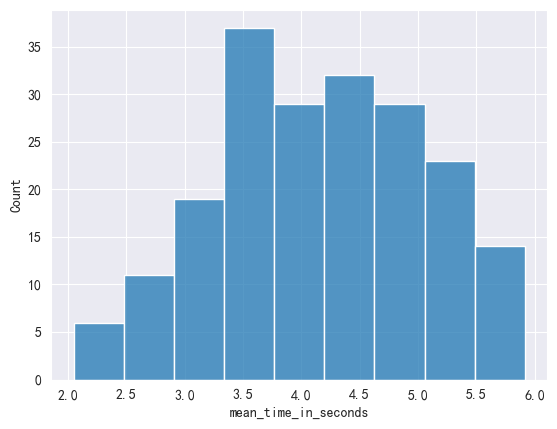

In [200]:
temp_df = sku_pick_datetime_diff_des_df.copy().iloc[:200]
temp_df['mean_time_in_seconds'] = temp_df['mean'].fillna(pd.Timedelta(seconds=0)).dt.total_seconds() / 3600
sns.histplot(temp_df, x = 'mean_time_in_seconds', kde=False)

<Axes: xlabel='mean_time_in_seconds', ylabel='count'>

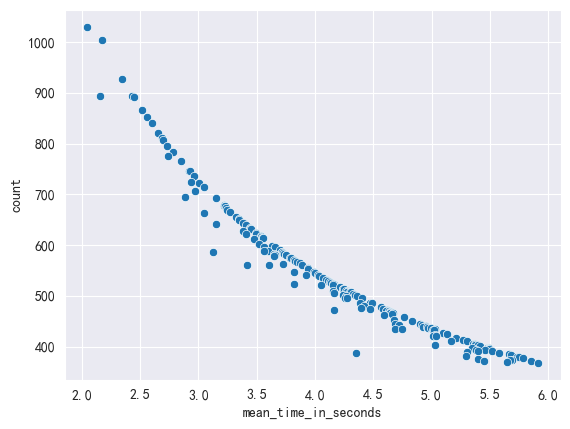

In [201]:
sns.scatterplot(temp_df, x = 'mean_time_in_seconds', y = 'count')

<Axes: xlabel='medium_time_in_seconds', ylabel='Count'>

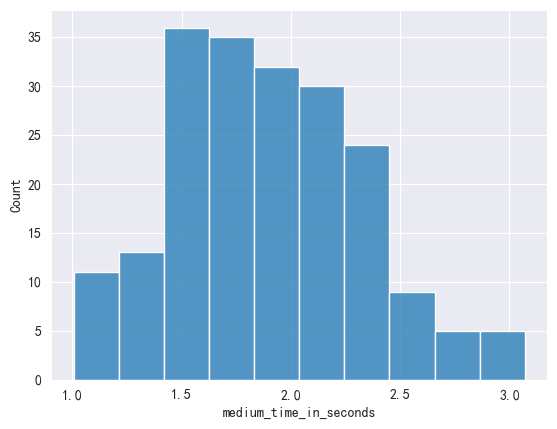

In [203]:
temp_df = sku_pick_datetime_diff_des_df.copy().iloc[:200]
temp_df['medium_time_in_seconds'] = temp_df['50%'].fillna(pd.Timedelta(seconds=0)).dt.total_seconds() / 3600
sns.histplot(temp_df, x = 'medium_time_in_seconds', kde=False)

<Axes: xlabel='medium_time_in_seconds', ylabel='count'>

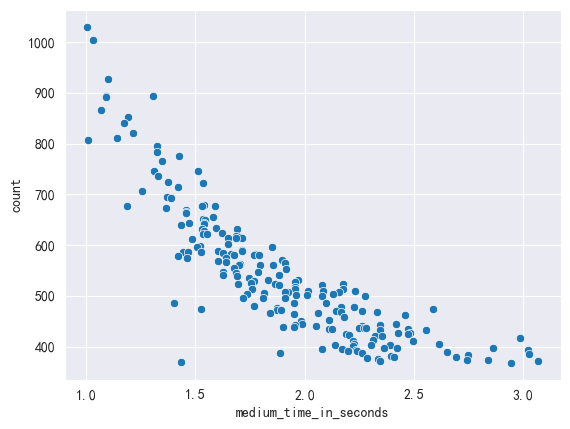

In [205]:
sns.scatterplot(temp_df, x = 'medium_time_in_seconds', y = 'count')

In [49]:
temp_df = sku_pick_datetime_diff_df.groupby('item_number')['diff_datetime'].describe()
top_n_sku = temp_df.sort_values(by='count', ascending=False).head(240).index
top_n_sku

Index(['80741461', '80804180', '80849460', '80752084', '80736222', '80815642',
       '80791692', '80813623', '80781269', '80813608',
       ...
       '80813430', '80799491', '80689257', '80786231', '80813616', '80807280',
       '80784370', '80820474', '80820168', '80735218'],
      dtype='object', name='item_number', length=240)

In [50]:
result_df['time_floor_to_hour'] = result_df['transaction_date'].dt.floor('H')
def get_sku_time_diff_hour(df: pd.DataFrame):
    sorted_df = df.sort_values(by='time_floor_to_hour')
    sorted_df['last_time_floor_to_hour'] = sorted_df['time_floor_to_hour'].shift(1)
    sorted_df['time_diff'] = sorted_df['time_floor_to_hour'] - sorted_df['last_time_floor_to_hour']
    new_df = sorted_df.loc[:, ['time_floor_to_hour', 'last_time_floor_to_hour', 'time_diff']]
    new_df.columns = ['current_datetime', 'last_datetime', 'diff_datetime']
    return new_df


sku_pick_datetime_diff_hour_df = result_df.groupby('item_number').apply(get_sku_time_diff_hour)
sku_pick_datetime_diff_hour_df.index = sku_pick_datetime_diff_hour_df.index.droplevel(1)
sku_pick_datetime_diff_hour_df

,current_datetime,last_datetime,diff_datetime
item_number,,,
80340467,2025-04-03 14:00:00,NaT,NaT
80340467,2025-04-08 02:00:00,2025-04-03 14:00:00,4 days 12:00:00
80340467,2025-04-08 03:00:00,2025-04-08 02:00:00,0 days 01:00:00
80340467,2025-04-09 01:00:00,2025-04-08 03:00:00,0 days 22:00:00
80340467,2025-04-10 09:00:00,2025-04-09 01:00:00,1 days 08:00:00
...,...,...,...
82329006,2025-06-22 17:00:00,2025-06-21 02:00:00,1 days 15:00:00
82329006,2025-06-24 02:00:00,2025-06-22 17:00:00,1 days 09:00:00
82329006,2025-06-24 03:00:00,2025-06-24 02:00:00,0 days 01:00:00


In [51]:
sku_pick_datetime_diff_hour_df.groupby('item_number')['diff_datetime'].describe()

,count,mean,std,min,25%,50%,75%,max
item_number,,,,,,,,
80340467,54,1 days 15:17:46.666666666,2 days 06:19:13.345518291,0 days 00:00:00,0 days 05:15:00,0 days 20:00:00,1 days 23:45:00,11 days 20:00:00
80340469,30,2 days 11:40:00,3 days 12:04:10.142847343,0 days 00:00:00,0 days 07:15:00,1 days 21:30:00,3 days 01:30:00,18 days 19:00:00
80340471,41,1 days 21:19:01.463414634,3 days 02:34:05.652763841,0 days 00:00:00,0 days 08:00:00,0 days 23:00:00,1 days 11:00:00,15 days 17:00:00
80371557,17,4 days 10:07:03.529411764,4 days 14:50:37.879670294,0 days 00:00:00,0 days 19:00:00,3 days 00:00:00,7 days 19:00:00,13 days 02:00:00
80371558,1,37 days 13:00:00,NaT,37 days 13:00:00,37 days 13:00:00,37 days 13:00:00,37 days 13:00:00,37 days 13:00:00
...,...,...,...,...,...,...,...,...
82327228,93,0 days 13:11:36.774193548,0 days 22:02:19.072083345,0 days 00:00:00,0 days 01:00:00,0 days 05:00:00,0 days 16:00:00,5 days 00:00:00
82327835,128,0 days 16:54:22.500000,1 days 04:51:06.837068044,0 days 00:00:00,0 days 01:00:00,0 days 04:00:00,0 days 20:15:00,7 days 15:00:00
82327837,142,0 days 15:17:44.788732394,1 days 06:20:10.904163700,0 days 00:00:00,0 days 01:00:00,0 days 04:30:00,0 days 13:00:00,10 days 14:00:00


### qty_in_cs 求和在小时维度的分布

In [52]:
group_by_date_and_hour_qty_in_cs_sum_df = result_df.groupby(['item_number', 'time_floor_to_hour'])['qty_in_cs'].sum()
group_by_date_and_hour_qty_in_cs_sum_df

item_number  time_floor_to_hour 
80340467     2025-04-03 14:00:00     36.0
             2025-04-08 02:00:00    576.0
             2025-04-08 03:00:00    144.0
             2025-04-09 01:00:00    468.0
             2025-04-10 09:00:00     36.0
                                    ...  
82329006     2025-06-22 17:00:00     24.0
             2025-06-24 02:00:00      7.0
             2025-06-24 03:00:00    110.0
             2025-06-25 20:00:00     36.0
             2025-06-27 20:00:00     24.0
Name: qty_in_cs, Length: 255177, dtype: float64

In [53]:
sku_hour_group_df = group_by_date_and_hour_qty_in_cs_sum_df.reset_index()
sku_hour_group_df['time_hour'] = sku_hour_group_df['time_floor_to_hour'].dt.hour
sku_hour_group_df = sku_hour_group_df.groupby(['item_number', 'time_hour'])['qty_in_cs'].sum().reset_index()
sku_hour_group_df

,item_number,time_hour,qty_in_cs
0,80340467,0,8352.0
1,80340467,1,1944.0
2,80340467,2,576.0
3,80340467,3,180.0
4,80340467,4,3996.0
...,...,...,...
39023,82329006,19,115.0
39024,82329006,20,300.0
39025,82329006,21,97.0
39026,82329006,22,95.0


In [54]:
top_sku = sku_hour_group_df.groupby('item_number')['qty_in_cs'].sum().sort_values(ascending=False).head(12)
top_sku

item_number
80786270    347328.0
80748616    253440.0
80784745    160704.0
80751559    158976.0
80683377    120384.0
80765805    101808.0
80765804     76608.0
80783756     74880.0
80783754     72576.0
80779816     53136.0
80748615     46080.0
80340467     43056.0
Name: qty_in_cs, dtype: float64

In [55]:
def plot_sku_hour_distribution(df: pd.DataFrame, ax: plt.Axes = None, sku: str = None):
    """
    绘制指定 SKU 的 qty_in_cs 按小时分布的直方图。

    参数:
    sku (str): 要分析的 SKU 编号。
    """
    # 筛选指定 SKU 的数据
    # sku_data = sku_hour_group_df[sku_hour_group_df['item_number'] == sku]

    if df.empty:
        print(f"未找到 SKU {sku} 的数据。")
        return

    if ax is None:
        fig, ax = plt.subplots()
    sns.barplot(x='time_hour', y='qty_in_cs', data=df, ax=ax)
    ax.set_title(f'SKU {sku}')
    ax.set_xlabel('小时')
    ax.set_ylabel('qty_in_cs 总和')
    # 设置tick旋转45
    ax.tick_params(axis='x', rotation=-45)

In [56]:
def get_sku_hour_distribution(df: pd.DataFrame):
    top_sku = df.groupby('item_number')['qty_in_cs'].sum().sort_values(ascending=False).head(12)
    df['time_hour'] = df['time_floor_to_hour'].dt.hour
    df = df.groupby(['item_number', 'time_hour'])['qty_in_cs'].sum().reset_index()
    # 示例：绘制指定 SKU 的小时分布直方图
    fig, axs = plt.subplots(nrows=4, ncols=3, sharex=True, sharey=True, figsize=(20, 8))
    axs = np.array(axs).flatten()
    for i, sku in enumerate(top_sku.index):
        sku_data = df[df['item_number'] == sku]
        plot_sku_hour_distribution(sku_data, axs[i], f"{sku}:{i + 1}")
    plt.show()
    return top_sku

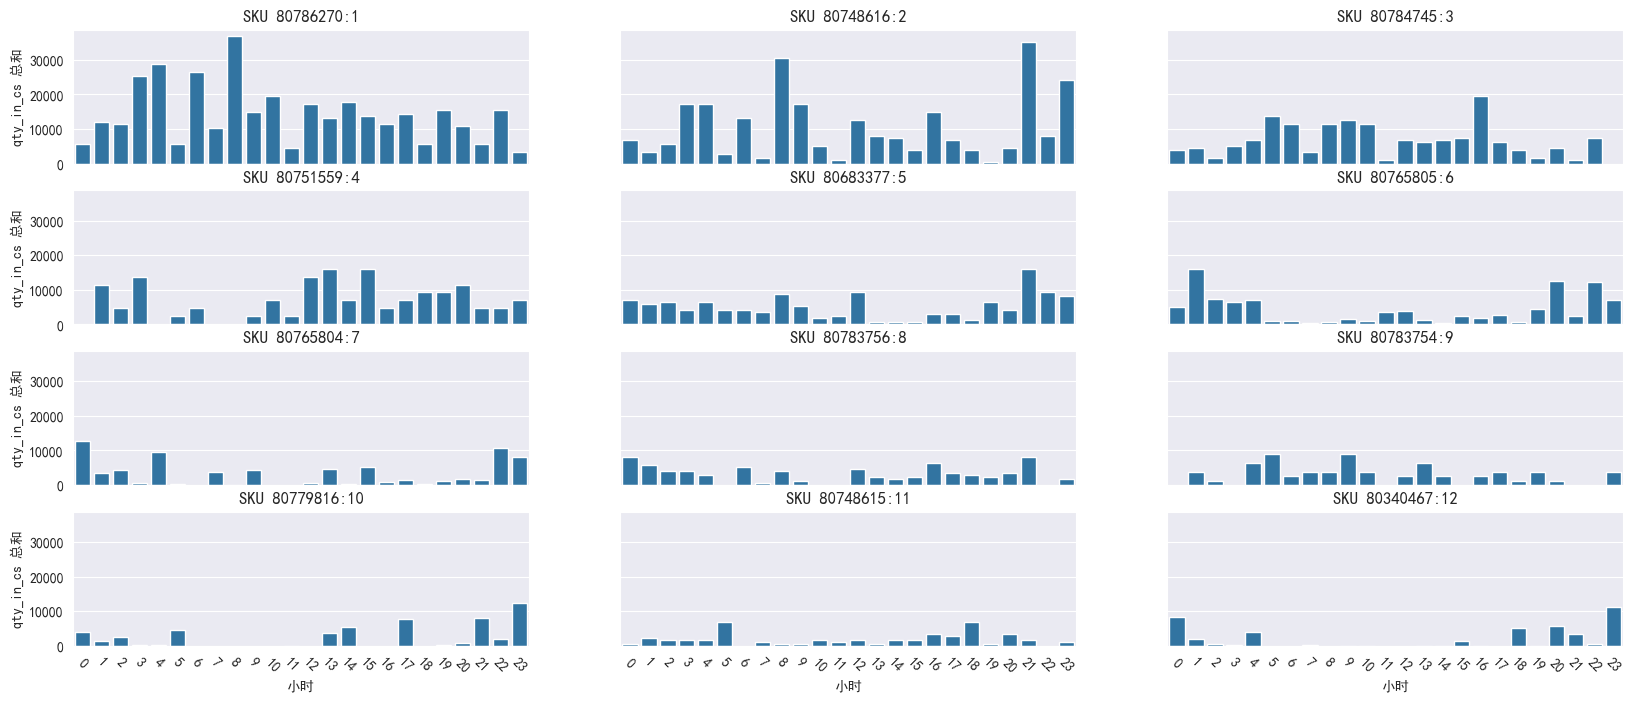

item_number
80786270    347328.0
80748616    253440.0
80784745    160704.0
80751559    158976.0
80683377    120384.0
80765805    101808.0
80765804     76608.0
80783756     74880.0
80783754     72576.0
80779816     53136.0
80748615     46080.0
80340467     43056.0
Name: qty_in_cs, dtype: float64

In [57]:
get_sku_hour_distribution(group_by_date_and_hour_qty_in_cs_sum_df.reset_index())

In [58]:
process_df = group_by_date_and_hour_qty_in_cs_sum_df.reset_index()
process_df['time_hour'] = process_df['time_floor_to_hour'].dt.hour
process_df = process_df.groupby(['item_number', 'time_hour'])['qty_in_cs'].sum().reset_index()
process_df

,item_number,time_hour,qty_in_cs
0,80340467,0,8352.0
1,80340467,1,1944.0
2,80340467,2,576.0
3,80340467,3,180.0
4,80340467,4,3996.0
...,...,...,...
39023,82329006,19,115.0
39024,82329006,20,300.0
39025,82329006,21,97.0
39026,82329006,22,95.0


### 捡货次数统计

In [59]:
group_by_date_and_hour_pick_times_df = result_df.groupby(['item_number', 'time_floor_to_hour']).size()
group_by_date_and_hour_pick_times_df = group_by_date_and_hour_pick_times_df.reset_index()
group_by_date_and_hour_pick_times_df.columns = ['item_number', 'time_floor_to_hour', 'pick_times']
group_by_date_and_hour_pick_times_df

,item_number,time_floor_to_hour,pick_times
0,80340467,2025-04-03 14:00:00,1
1,80340467,2025-04-08 02:00:00,1
2,80340467,2025-04-08 03:00:00,1
3,80340467,2025-04-09 01:00:00,1
4,80340467,2025-04-10 09:00:00,1
...,...,...,...
255172,82329006,2025-06-22 17:00:00,1
255173,82329006,2025-06-24 02:00:00,1
255174,82329006,2025-06-24 03:00:00,1
255175,82329006,2025-06-25 20:00:00,1


In [60]:
# 统计不同天不同 SKU 的拣选次数
group_by_date_and_sku_pick_times_df = result_df.groupby(['item_number', result_df['transaction_date'].dt.date]).size()
group_by_date_and_sku_pick_times_df = group_by_date_and_sku_pick_times_df.reset_index()
group_by_date_and_sku_pick_times_df.columns = ['item_number', 'transaction_date', 'pick_times']

# 显示结果
group_by_date_and_sku_pick_times_df

,item_number,transaction_date,pick_times
0,80340467,2025-04-03,1
1,80340467,2025-04-08,2
2,80340467,2025-04-09,1
3,80340467,2025-04-10,1
4,80340467,2025-04-11,1
...,...,...,...
84052,82329006,2025-06-21,3
84053,82329006,2025-06-22,1
84054,82329006,2025-06-24,2
84055,82329006,2025-06-25,1


In [61]:
temp_df = group_by_date_and_sku_pick_times_df.groupby('item_number')['pick_times'].describe()
temp_df['sum'] = group_by_date_and_sku_pick_times_df.groupby('item_number')['pick_times'].sum()
temp_df

,count,mean,std,min,25%,50%,75%,max,sum
item_number,,,,,,,,,
80340467,34.0,1.617647,0.853325,1.0,1.0,1.0,2.00,5.0,55
80340469,23.0,1.347826,0.775107,1.0,1.0,1.0,1.00,4.0,31
80340471,28.0,1.500000,0.922958,1.0,1.0,1.0,2.00,4.0,42
80371557,15.0,1.200000,0.414039,1.0,1.0,1.0,1.00,2.0,18
80371558,2.0,1.000000,0.000000,1.0,1.0,1.0,1.00,1.0,2
...,...,...,...,...,...,...,...,...,...
82327228,34.0,2.764706,2.045821,1.0,1.0,2.0,3.75,9.0,94
82327835,46.0,2.804348,2.082942,1.0,1.0,2.0,4.00,9.0,129
82327837,48.0,2.979167,2.036785,1.0,1.0,2.0,5.00,8.0,143


<Axes: ylabel='Frequency'>

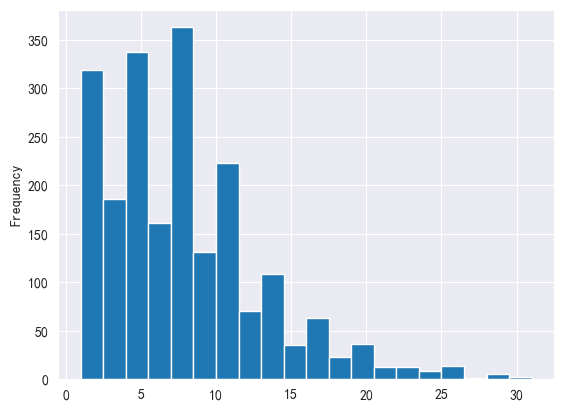

In [62]:
temp_df['max'].plot.hist(bins=20)

In [63]:
temp_df = group_by_date_and_hour_pick_times_df.groupby('item_number')['pick_times'].describe()
temp_df['sum'] = group_by_date_and_hour_pick_times_df.groupby('item_number')['pick_times'].sum()
temp_df

,count,mean,std,min,25%,50%,75%,max,sum
item_number,,,,,,,,,
80340467,49.0,1.122449,0.389051,1.0,1.0,1.0,1.0,3.0,55
80340469,30.0,1.033333,0.182574,1.0,1.0,1.0,1.0,2.0,31
80340471,37.0,1.135135,0.346583,1.0,1.0,1.0,1.0,2.0,42
80371557,16.0,1.125000,0.341565,1.0,1.0,1.0,1.0,2.0,18
80371558,2.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0,2
...,...,...,...,...,...,...,...,...,...
82327228,81.0,1.160494,0.431764,1.0,1.0,1.0,1.0,3.0,94
82327835,106.0,1.216981,0.497704,1.0,1.0,1.0,1.0,3.0,129
82327837,123.0,1.162602,0.450391,1.0,1.0,1.0,1.0,4.0,143


<Axes: ylabel='Frequency'>

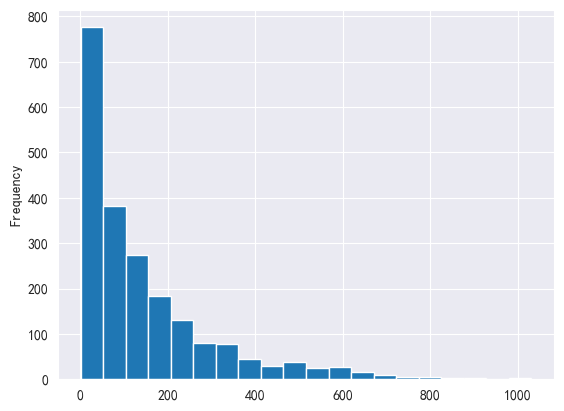

In [64]:
temp_df['sum'].plot.hist(bins=20)

In [65]:
# # 摘除次数大于6次的sku
# group_by_date_and_hour_pick_times_df.groupby('item_number')['pick_times'].describe().to_csv(
#         "../data/result1/不同单小时拣选次数统计.csv")

In [66]:
sku_hour_group_df = group_by_date_and_hour_pick_times_df.reset_index()
sku_hour_group_df['time_hour'] = sku_hour_group_df['time_floor_to_hour'].dt.hour
sku_hour_group_df = sku_hour_group_df.groupby(['item_number', 'time_hour'])['pick_times'].sum().reset_index()
sku_hour_group_df

,item_number,time_hour,pick_times
0,80340467,0,7
1,80340467,1,3
2,80340467,2,1
3,80340467,3,2
4,80340467,4,3
...,...,...,...
39023,82329006,19,2
39024,82329006,20,10
39025,82329006,21,6
39026,82329006,22,2


In [67]:
sku_hour_group_df.groupby('item_number')['pick_times'].sum().sort_values(ascending=False) / 91

item_number
80741461    11.329670
80804180    11.043956
80849460    10.208791
80752084     9.835165
80736222     9.824176
              ...    
80859235     0.010989
80859241     0.010989
80859245     0.010989
80859248     0.010989
80870411     0.010989
Name: pick_times, Length: 2113, dtype: float64

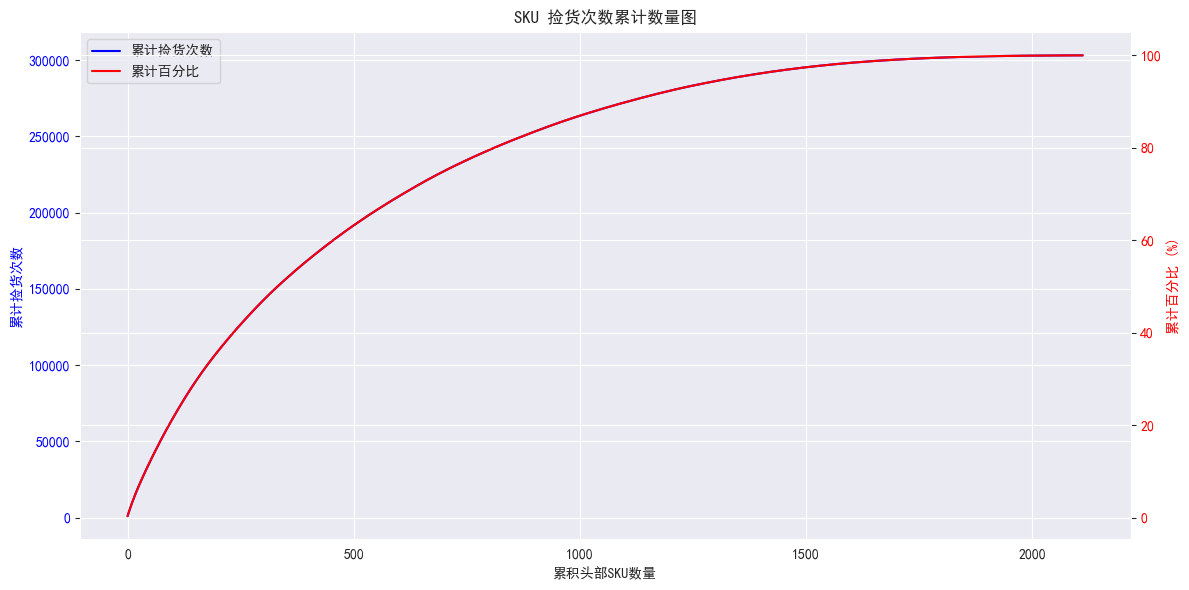

In [68]:
import matplotlib.pyplot as plt

# 计算每个 item_number 的 pick_times 总和并排序
pick_times_sum = sku_hour_group_df.groupby('item_number')['pick_times'].sum().sort_values(ascending=False)
pick_times_sum.index = np.arange(len(pick_times_sum))
# 计算累计数量
cumulative_sum = pick_times_sum.cumsum()

# 计算累计百分比
total_sum = cumulative_sum.iloc[-1]
cumulative_percentage = cumulative_sum / total_sum * 100

# 绘制累计数量图
fig, ax1 = plt.subplots(figsize=(12, 6))

# 绘制累计数量曲线
line1 = ax1.plot(cumulative_sum, color='blue', label='累计捡货次数')
ax1.set_title('SKU 捡货次数累计数量图')
ax1.set_xlabel('累积头部SKU数量')
# todo：总拣选次数40%，60%需要多少SKU

ax1.set_ylabel('累计捡货次数', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)

# 创建第二个 y 轴
ax2 = ax1.twinx()

# 绘制累计百分比曲线
line2 = ax2.plot(cumulative_percentage, color='red', label='累计百分比')
ax2.set_ylabel('累计百分比 (%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# 合并图例
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [69]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 计算每个 item_number 的 pick_times 总和并排序
pick_times_sum = sku_hour_group_df.groupby('item_number')['pick_times'].sum().sort_values(ascending=False)
# 获取原始SKU编号用于标注 (可选，如果需要显示具体SKU)
# top_sku_ids = pick_times_sum.index
pick_times_sum.index = np.arange(len(pick_times_sum))  # X轴为SKU的累计数量

# 计算累计数量
cumulative_sum = pick_times_sum.cumsum()

# 计算累计百分比
total_sum = cumulative_sum.iloc[-1]
cumulative_percentage = cumulative_sum / total_sum * 100

# 创建带有双Y轴的图表
fig = make_subplots(specs=[[{"secondary_y": True}]])

# 添加累计捡货次数曲线 (Y1轴)
fig.add_trace(
        go.Scatter(x=pick_times_sum.index, y=cumulative_sum, name="累计捡货次数", line=dict(color='blue')),
        secondary_y=False,
)

# 添加累计百分比曲线 (Y2轴)
fig.add_trace(
        go.Scatter(x=pick_times_sum.index, y=cumulative_percentage, name="累计百分比", line=dict(color='red')),
        secondary_y=True,
)

# --- 添加标记 ---
# 找到40%和60%水位点的索引
idx_40_percent = (cumulative_percentage >= 40).idxmax()
idx_60_percent = (cumulative_percentage >= 60).idxmax()

# 获取对应的累积SKU数量和累积拣选次数
num_sku_40_percent = pick_times_sum.index[idx_40_percent]
cum_picks_40_percent = cumulative_sum.loc[idx_40_percent]
actual_percentage_40 = cumulative_percentage.loc[idx_40_percent]

num_sku_60_percent = pick_times_sum.index[idx_60_percent]
cum_picks_60_percent = cumulative_sum.loc[idx_60_percent]
actual_percentage_60 = cumulative_percentage.loc[idx_60_percent]

# 添加40%水位标记
fig.add_vline(x=num_sku_40_percent, line_width=1, line_dash="dash", line_color="green")
fig.add_annotation(
        x=num_sku_40_percent, y=actual_percentage_40, ax=0, ay=-40,  # ay调整标注的垂直位置
        text=f"Top {num_sku_40_percent} SKUs<br>{actual_percentage_40:.1f}% picks",
        showarrow=True, arrowhead=1, arrowcolor="green",
        bgcolor="rgba(255,255,255,0.8)", bordercolor="green", borderwidth=1,
        secondary_y=True  # 确保标注与百分比轴对齐
)
fig.add_annotation(
        x=num_sku_40_percent, y=cum_picks_40_percent * 1.1, ax=0, ay=40,
        text=f"累计拣选: {cum_picks_40_percent}",
        showarrow=True, arrowhead=1, arrowcolor="green",
        bgcolor="rgba(255,255,255,0.8)", bordercolor="green", borderwidth=1,
        secondary_y=False  # 确保标注与拣选次数轴对齐
)

# 添加60%水位标记
fig.add_vline(x=num_sku_60_percent, line_width=1, line_dash="dash", line_color="purple")
fig.add_annotation(
        x=num_sku_60_percent, y=actual_percentage_60, ax=0, ay=-60,
        text=f"Top {num_sku_60_percent} SKUs<br>{actual_percentage_60:.1f}% picks",
        showarrow=True, arrowhead=1, arrowcolor="purple",
        bgcolor="rgba(255,255,255,0.8)", bordercolor="purple", borderwidth=1,
        secondary_y=True
)
fig.add_annotation(
        x=num_sku_60_percent, y=cum_picks_60_percent, ax=0, ay=60,
        text=f"累计拣选: {cum_picks_60_percent}",
        showarrow=True, arrowhead=1, arrowcolor="purple",
        bgcolor="rgba(255,255,255,0.8)", bordercolor="purple", borderwidth=1,
        secondary_y=False
)
# --- 标记结束 ---

# 设置图表标题和坐标轴标签
fig.update_layout(
        title_text='SKU 捡货次数累计数量图 (带40%和60%标记)',
        xaxis_title='累积头部SKU数量'
)

# 设置Y轴标签
fig.update_yaxes(title_text="累计捡货次数", color='blue', secondary_y=False)
fig.update_yaxes(title_text="累计百分比 (%)", color='red', secondary_y=True)

# 显示图表
fig.show()

In [145]:
481 / 2399

0.20050020842017507

In [70]:
top_sku = sku_hour_group_df.groupby('item_number')['pick_times'].sum().sort_values(ascending=False).head(12)
top_sku

item_number
80741461    1031
80804180    1005
80849460     929
80752084     895
80736222     894
80815642     892
80791692     868
80813623     854
80781269     841
80813608     822
80781266     812
80736560     808
Name: pick_times, dtype: int64

In [71]:
def plot_sku_hour_distribution(df: pd.DataFrame, ax: plt.Axes = None, sku: str = None):
    """
    绘制指定 SKU 的 qty_in_cs 按小时分布的直方图。

    参数:
    sku (str): 要分析的 SKU 编号。
    """
    # 筛选指定 SKU 的数据
    # sku_data = sku_hour_group_df[sku_hour_group_df['item_number'] == sku]

    if df.empty:
        print(f"未找到 SKU {sku} 的数据。")
        return

    if ax is None:
        fig, ax = plt.subplots()
    sns.barplot(x='time_hour', y='pick_times', data=df, ax=ax)
    ax.set_title(f'SKU {sku}')
    ax.set_xlabel('小时')
    ax.set_ylabel('捡货次数 总和')
    # 设置tick旋转45
    ax.tick_params(axis='x', rotation=-45)

In [72]:
def get_sku_hour_distribution(df: pd.DataFrame):
    top_sku = df.groupby('item_number')['pick_times'].sum().sort_values(ascending=False).head(12)
    df['time_hour'] = df['time_floor_to_hour'].dt.hour
    df = df.groupby(['item_number', 'time_hour'])['pick_times'].sum().reset_index()
    # 示例：绘制指定 SKU 的小时分布直方图
    fig, axs = plt.subplots(nrows=4, ncols=3, sharex=True, sharey=True, figsize=(20, 8))
    axs = np.array(axs).flatten()
    for i, sku in enumerate(top_sku.index):
        sku_data = df[df['item_number'] == sku]
        plot_sku_hour_distribution(sku_data, axs[i], f"{sku}:{i + 1}")
    plt.show()
    return top_sku

In [73]:
process_df = group_by_date_and_hour_pick_times_df.reset_index()
process_df['time_hour'] = process_df['time_floor_to_hour'].dt.hour
process_df = process_df.groupby(['item_number', 'time_hour'])['pick_times'].sum().reset_index()
process_df

,item_number,time_hour,pick_times
0,80340467,0,7
1,80340467,1,3
2,80340467,2,1
3,80340467,3,2
4,80340467,4,3
...,...,...,...
39023,82329006,19,2
39024,82329006,20,10
39025,82329006,21,6
39026,82329006,22,2


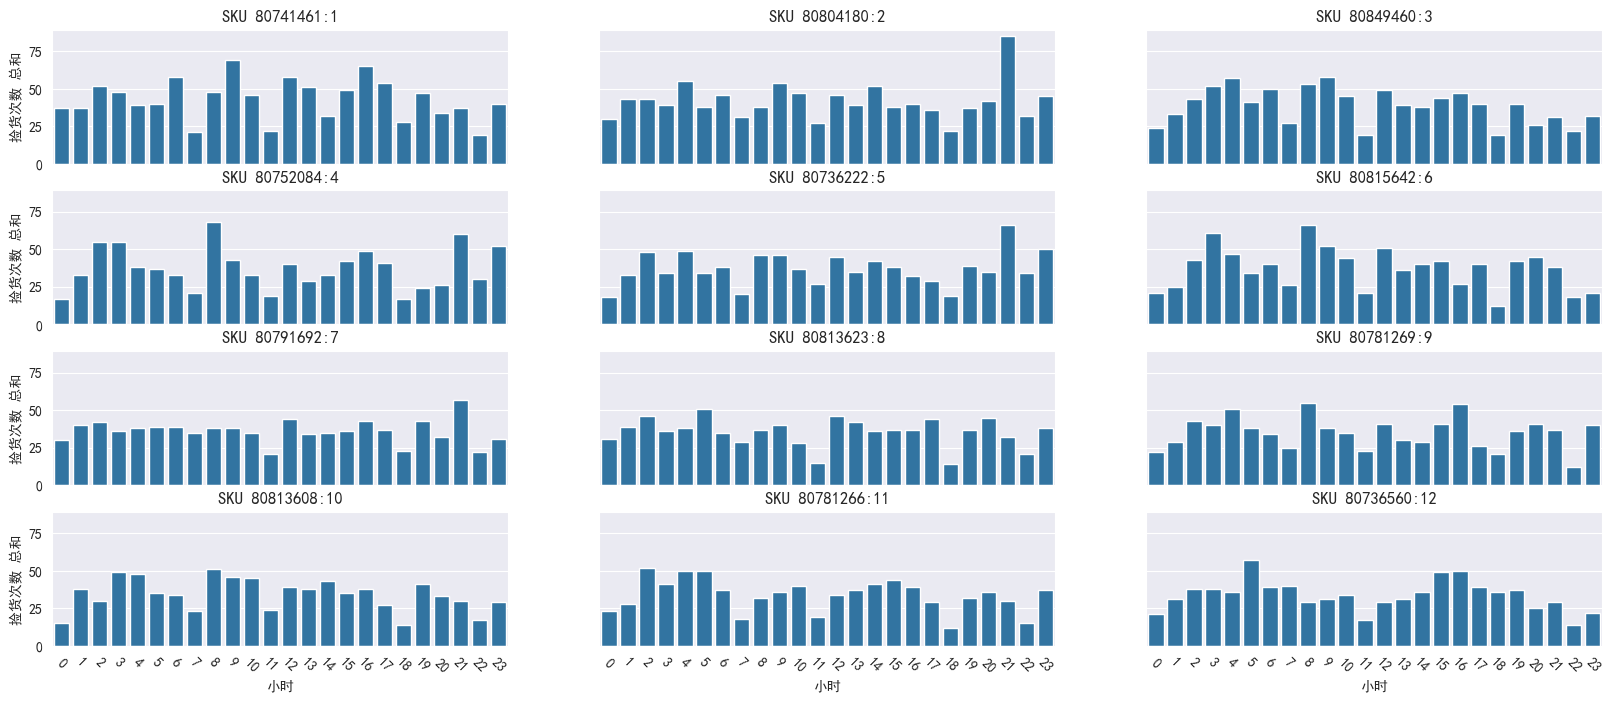

item_number
80741461    1031
80804180    1005
80849460     929
80752084     895
80736222     894
80815642     892
80791692     868
80813623     854
80781269     841
80813608     822
80781266     812
80736560     808
Name: pick_times, dtype: int64

In [76]:
get_sku_hour_distribution(group_by_date_and_hour_pick_times_df.reset_index())

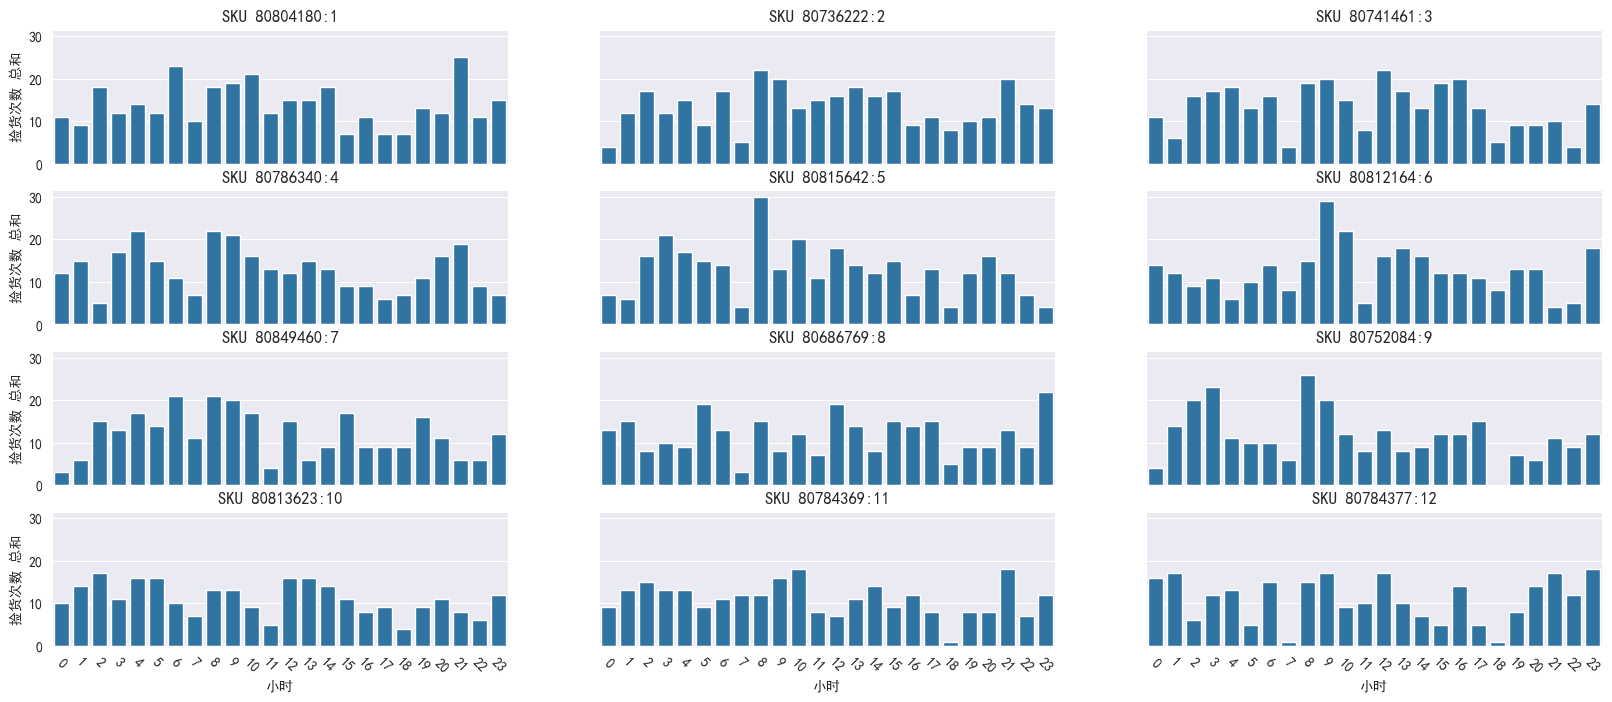

item_number
80804180    335
80736222    324
80741461    318
80786340    309
80815642    308
80812164    301
80849460    287
80686769    284
80752084    278
80813623    265
80784369    264
80784377    264
Name: pick_times, dtype: int64

In [77]:
get_sku_hour_distribution(group_by_date_and_hour_pick_times_df.reset_index().query("time_floor_to_hour.dt.month == 4"))

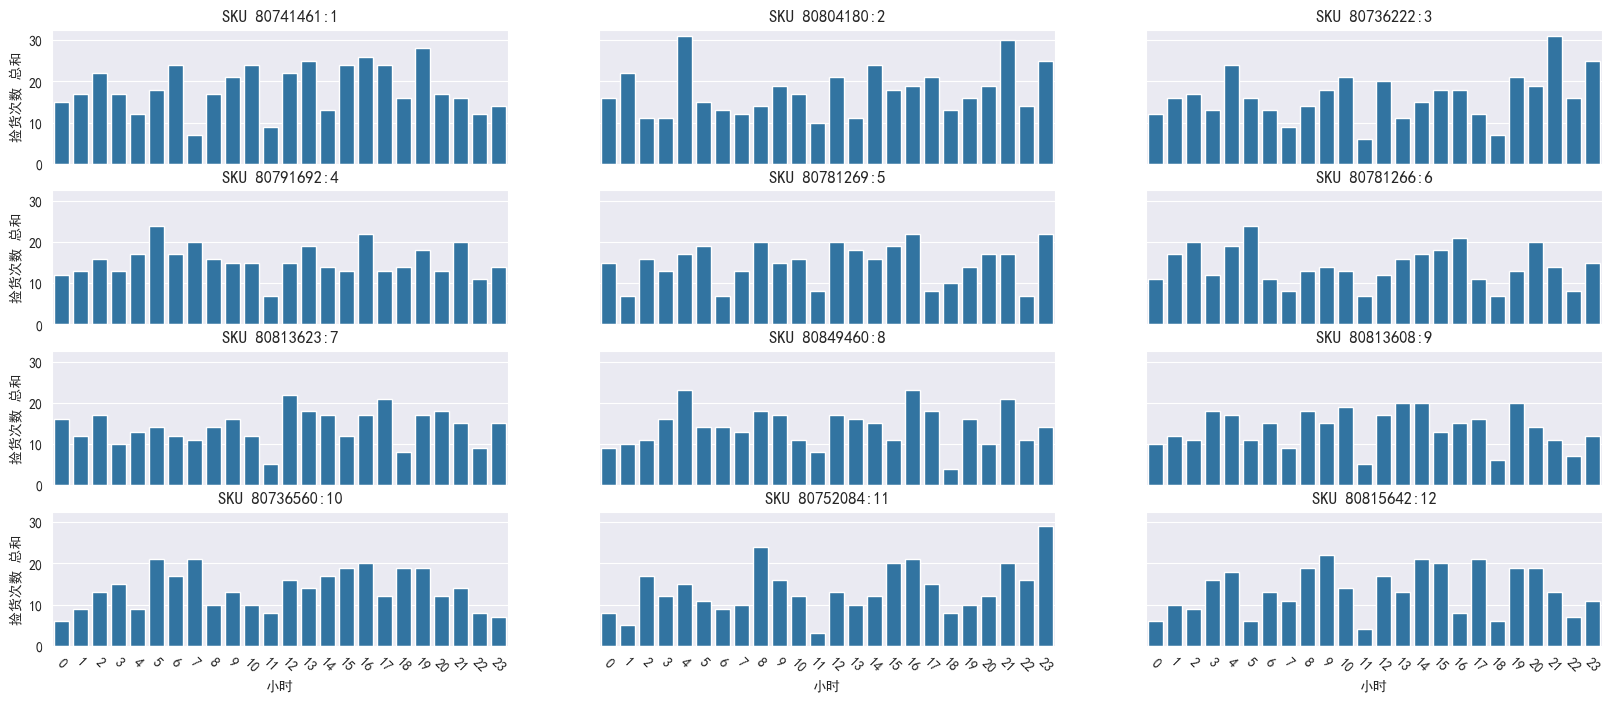

item_number
80741461    440
80804180    422
80736222    392
80791692    371
80781269    356
80781266    341
80813623    341
80849460    340
80813608    331
80736560    329
80752084    328
80815642    323
Name: pick_times, dtype: int64

In [78]:
get_sku_hour_distribution(group_by_date_and_hour_pick_times_df.reset_index().query("time_floor_to_hour.dt.month == 5"))

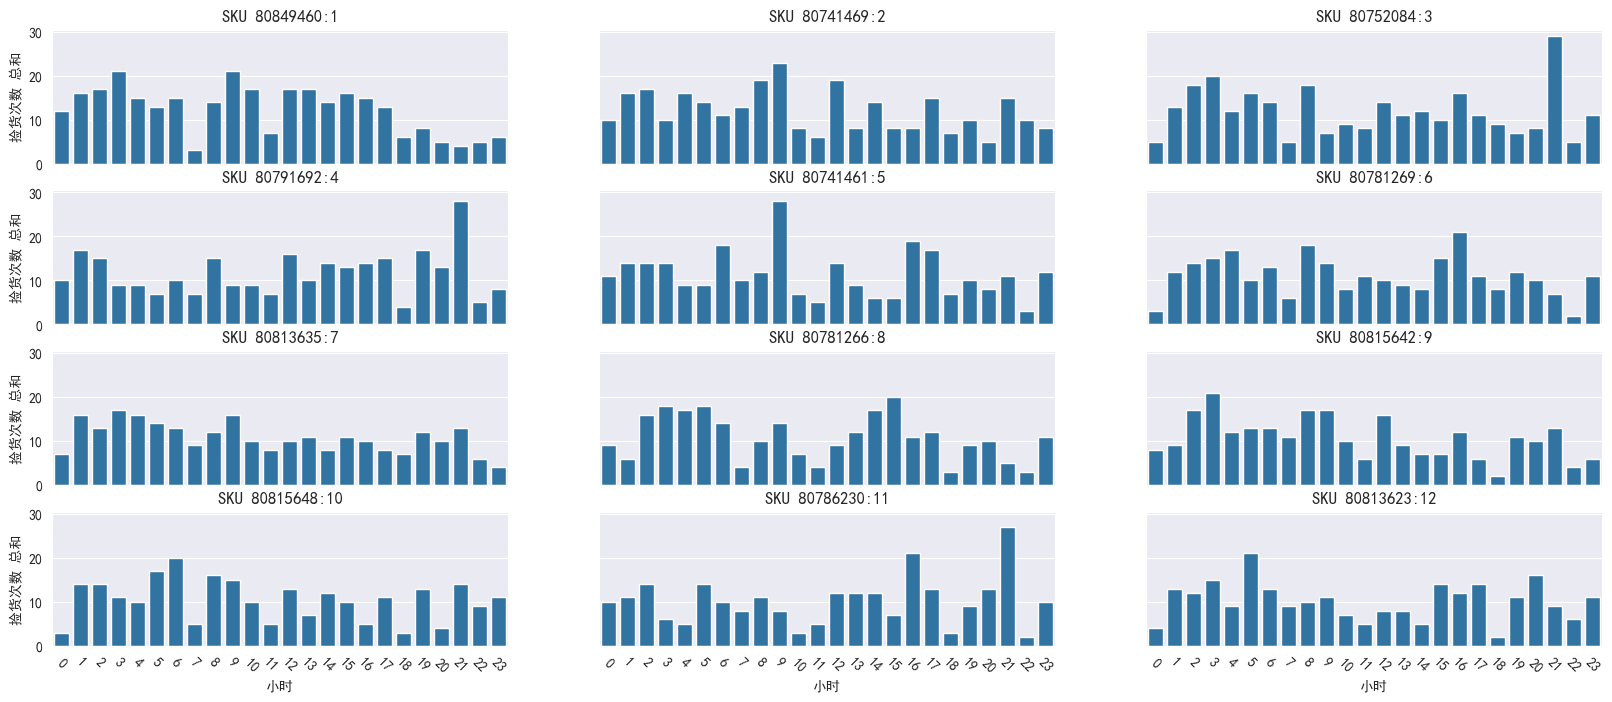

item_number
80849460    297
80741469    290
80752084    288
80791692    281
80741461    273
80781269    265
80813635    261
80781266    259
80815642    257
80815648    252
80786230    246
80813623    245
Name: pick_times, dtype: int64

In [79]:
get_sku_hour_distribution(group_by_date_and_hour_pick_times_df.reset_index().query("time_floor_to_hour.dt.month == 6"))

### 拣选高峰期分析

In [80]:
group_by_date_and_hour_pick_times_df = result_df.groupby(['time_floor_to_hour']).size()
group_by_date_and_hour_pick_times_df = group_by_date_and_hour_pick_times_df.reset_index()
group_by_date_and_hour_pick_times_df.columns = ['time_floor_to_hour', 'pick_times']
group_by_date_and_hour_pick_times_df  # todo: 按照小时，不用天

,time_floor_to_hour,pick_times
0,2025-04-01 08:00:00,198
1,2025-04-01 09:00:00,258
2,2025-04-01 10:00:00,218
3,2025-04-01 11:00:00,109
4,2025-04-01 12:00:00,221
...,...,...
1899,2025-07-01 03:00:00,192
1900,2025-07-01 04:00:00,129
1901,2025-07-01 05:00:00,98
1902,2025-07-01 06:00:00,55


In [81]:
def plot_sku_hour_distribution(df: pd.DataFrame, ax: plt.Axes = None, sku: str = None):
    """
    绘制指定 SKU 的 qty_in_cs 按小时分布的直方图。

    参数:
    sku (str): 要分析的 SKU 编号。
    """
    # 筛选指定 SKU 的数据
    # sku_data = sku_hour_group_df[sku_hour_group_df['item_number'] == sku]

    if df.empty:
        print(f"未找到 SKU {sku} 的数据。")
        return

    if ax is None:
        fig, ax = plt.subplots()
    sns.barplot(x='time_hour', y='pick_times', data=df, ax=ax)
    ax.set_title(f'捡货高峰期')
    ax.set_xlabel('小时')
    ax.set_ylabel('捡货次数 总和')
    # 设置tick旋转45
    ax.tick_params(axis='x', rotation=-45)

In [82]:
def get_sku_hour_distribution(df: pd.DataFrame):
    df['time_hour'] = df['time_floor_to_hour'].dt.hour
    df = df.groupby(['time_hour'])['pick_times'].sum().reset_index()
    # 示例：绘制指定 SKU 的小时分布直方图
    fig, ax = plt.subplots()
    plot_sku_hour_distribution(df, ax)
    plt.show()

In [83]:
process_df = group_by_date_and_hour_pick_times_df.reset_index()
process_df['time_hour'] = process_df['time_floor_to_hour'].dt.hour
process_df = process_df.groupby(['time_hour'])['pick_times'].sum().reset_index()
process_df

,time_hour,pick_times
0,0,11039
1,1,13141
2,2,14708
3,3,14885
4,4,14858
5,5,13537
6,6,13395
7,7,7728
8,8,15923
9,9,14890


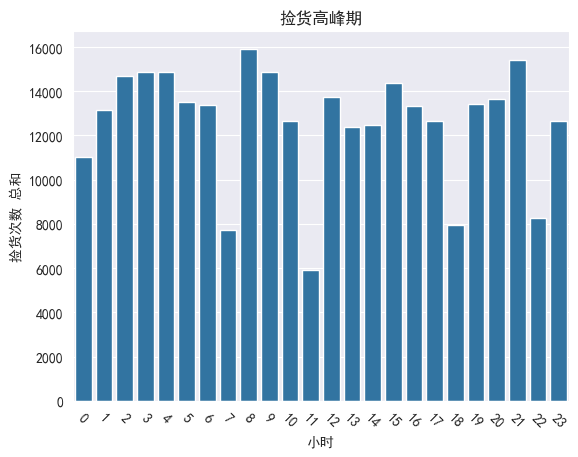

In [84]:
get_sku_hour_distribution(group_by_date_and_hour_pick_times_df.reset_index())

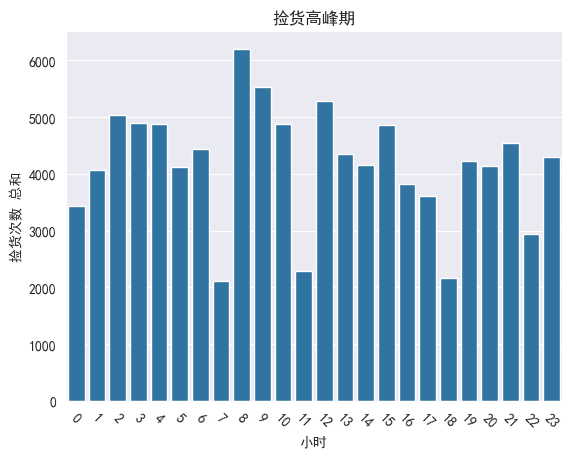

In [85]:
get_sku_hour_distribution(group_by_date_and_hour_pick_times_df.reset_index().query("time_floor_to_hour.dt.month == 4"))

### top n sku分析

In [86]:
group_by_date_and_hour_pick_times_df = result_df.groupby(['item_number', 'time_floor_to_hour']).agg(
        qty_in_cs_sum=('qty_in_cs', 'sum'), pick_times_count=('qty_in_cs', 'count'))
group_by_date_and_hour_pick_times_df.columns = ['qty_in_cs', 'pick_times']
top_n_sku_pick_info_by_hour_df = group_by_date_and_hour_pick_times_df.query("item_number in @top_n_sku").reset_index()
top_n_sku_pick_info_by_hour_df['date'] = top_n_sku_pick_info_by_hour_df['time_floor_to_hour'].dt.date
daily_sku_summary_df = top_n_sku_pick_info_by_hour_df.groupby(['item_number', 'date']).agg(
        total_qty_in_cs=('qty_in_cs', 'sum'),
        total_pick_times=('pick_times', 'sum')
).reset_index()
daily_sku_summary_df


,item_number,date,total_qty_in_cs,total_pick_times
0,80686080,2025-04-01,3.0,1
1,80686080,2025-04-02,52.0,5
2,80686080,2025-04-03,14.0,1
3,80686080,2025-04-04,10.0,1
4,80686080,2025-04-08,24.0,5
...,...,...,...,...
19404,82313296,2025-06-26,163.0,19
19405,82313296,2025-06-27,70.0,8
19406,82313296,2025-06-28,40.0,7
19407,82313296,2025-06-30,2.0,1


In [208]:
def plot_sku_daily_distribution(df, skus_to_plot=None, total_days=92):
    """
    使用 Plotly 绘制指定 SKU 的每日 qty_in_cs 和 pick_times 分布，
    支持交互式 SKU 选择，并显示额外统计信息和阈值线。
    qty_in_cs 和 pick_times 分别在独立的子图中显示。

    参数:
    df (pd.DataFrame): 包含 'item_number', 'date', 'total_qty_in_cs', 'total_pick_times' 的 DataFrame。
    skus_to_plot (list, optional): 要在下拉菜单中提供的 SKU 列表。如果为 None，则使用 df 中的所有唯一 SKU。
    total_days (int): 用于计算百分比的总天数，默认为92。
    """
    fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                        subplot_titles=("每日总箱数 (qty_in_cs)", "每日总拣选次数 (pick_times)"))

    # 确保 'date' 列是 datetime 类型
    if not pd.api.types.is_datetime64_any_dtype(df['date']):
        df['date'] = pd.to_datetime(df['date'])

    if skus_to_plot is None:
        skus_to_plot = sorted(df['item_number'].unique())
    else:
        # 确保 skus_to_plot 中的 SKU 存在于 df 中并排序
        skus_to_plot = sorted(list(set(skus_to_plot) & set(df['item_number'].unique())))

    if not skus_to_plot:
        print("没有可供绘制的SKU。请检查输入数据和skus_to_plot列表。")
        return

    # 为所有SKU添加轨迹
    for sku in skus_to_plot:
        sku_data = df[df['item_number'] == sku].sort_values(by='date')
        # Qty trace
        fig.add_trace(
                go.Scatter(
                        x=sku_data['date'], y=sku_data['total_qty_in_cs'], name=f'SKU {sku} - Qty',
                        mode='lines+markers', visible=True, legendgroup=sku, legendgrouptitle_text=sku,
                        line=dict(shape='spline'),  # 添加平滑处理
                        opacity=0.5
                ),
                row=1, col=1,
        )
        # Pick times trace
        fig.add_trace(
                go.Scatter(
                        x=sku_data['date'], y=sku_data['total_pick_times'], name=f'SKU {sku} - Picks',
                        mode='lines+markers', visible=True, legendgroup=sku,
                        # Removed legendgrouptitle_text to avoid duplicate title
                        line=dict(shape='spline'),  # 添加平滑处理
                        opacity=0.5
                ),
                row=2, col=1,
        )

    buttons = []

    # “所有 SKU” 按钮
    all_skus_trace_visibility = [True] * (len(skus_to_plot) * 2)  # 2 traces per SKU
    buttons.append(dict(
            label="所有 SKU",
            method="update",
            args=[
                {
                    "visible":                       all_skus_trace_visibility,
                    "shapes[0].visible":             False,  # 隐藏水位线
                    "layout.annotations[0].visible": False  # 隐藏统计信息注解
                },
                {  # Layout updates
                    "title_text":       "所有 SKU 每日拣选量和拣选次数分布",
                    "xaxis.autorange":  True,  # 确保X轴根据数据自动调整范围
                    "xaxis2.autorange": True  # 对第二个（共享的）X轴也应用自动调整范围
                }
            ]
    ))

    # 为每个单独的SKU创建按钮
    for i, sku in enumerate(skus_to_plot):
        sku_data_for_stats = df[df['item_number'] == sku]
        days_gt_6 = sku_data_for_stats[sku_data_for_stats['total_pick_times'] > 6].shape[0]
        percentage_gt_6 = (days_gt_6 / total_days) * 100 if total_days > 0 else 0
        total_picks = sku_data_for_stats['total_pick_times'].sum()
        total_qty = sku_data_for_stats['total_qty_in_cs'].sum()

        main_title_for_sku = f"SKU {sku} 每日拣选量和拣选次数分布"
        stats_text_for_annotation = (f">6次拣选天数: {days_gt_6} ({percentage_gt_6:.1f}%) | "
                                     f"总拣选: {total_picks} | 总数量: {total_qty}")

        current_sku_trace_visibility = [False] * (len(skus_to_plot) * 2)
        current_sku_trace_visibility[i * 2] = True  # Qty 轨迹 for SKU i
        current_sku_trace_visibility[i * 2 + 1] = True  # Pick times 轨迹 for SKU i

        buttons.append(dict(
                label=f"SKU {sku}",
                method="update",
                args=[
                    {
                        "visible":                       current_sku_trace_visibility,
                        "shapes[0].visible":             True,  # 显示水位线
                        "layout.annotations[0].text":    stats_text_for_annotation,
                        "layout.annotations[0].visible": True
                    },
                    {  # Layout updates
                        "title_text":       main_title_for_sku,
                        "xaxis.autorange":  True,  # 确保X轴根据数据自动调整范围
                        "xaxis2.autorange": True  # 对第二个（共享的）X轴也应用自动调整范围
                    }
                ]
        ))

    # 添加横线形状 (水位线 for pick_times)
    fig.add_shape(
            type="line",
            xref="paper", x0=0, x1=1,
            yref="y2", y0=6, y1=6,  # y2 refers to the y-axis of the second subplot
            line=dict(color="Red", dash="dash", width=2),
            visible=True,  # 初始可见，由按钮控制
            name="6次拣选阈值",
            row=2, col=1  # Specify shape belongs to the second subplot
    )

    fig.update_layout(
            annotations=[
                go.layout.Annotation(
                        text="", showarrow=False,
                        xref="paper", yref="paper",
                        x=0.5, y=1.06,  # Adjusted y for annotation to be above subplots titles
                        xanchor='center', yanchor='bottom',
                        align='center',
                        font=dict(size=10),
                        visible=False
                )
            ],
            updatemenus=[dict(
                    active=0,
                    buttons=buttons,
                    direction="down", pad={"r": 10, "t": 10}, showactive=True,
                    x=0.2, xanchor="right",
                    y=1.15, yanchor="top"  # Adjusted y for updatemenus
            )],
            title_text="每日拣选量和拣选次数分布",  # Initial main title
            title_x=0.5,  # Center the main title
            height=700,  # Adjust height to accommodate two subplots
            legend_title_text='SKU',
            legend_tracegroupgap=20  # Add some space between legend groups if many SKUs
    )

    # Update x-axis title for the shared x-axis
    fig.update_xaxes(title_text='日期', row=2, col=1, range=[df['date'].min(), df['date'].max()])
    # Update y-axis titles for each subplot
    fig.update_yaxes(title_text="<b>总箱数 (qty_in_cs)</b>", row=1, col=1)
    fig.update_yaxes(title_text="<b>总拣选次数 (pick_times)</b>", row=2, col=1)

    fig.show()


# 示例：
# 1. 绘制 daily_sku_summary_df 中所有 SKU 的数据 (下拉菜单将包含所有这些SKU)
# plot_sku_daily_distribution(daily_sku_summary_df)

# 2. 如果只想在下拉菜单中看到 top_93_sku 的选项:
#    首先筛选 DataFrame
# filtered_top93_df = daily_sku_summary_df[daily_sku_summary_df['item_number'].isin(list(top_93_sku))]
# plot_sku_daily_distribution(filtered_top93_df, skus_to_plot=list(top_93_sku)) # skus_to_plot 可以省略，函数会自动从df中获取

# 3. 如果只想在下拉菜单中看到 top_93_sku 中的前5个SKU:
skus_subset = list(top_n_sku[:10])
# 确保 filtered_subset_df 只包含 skus_subset 中的 SKU 数据，并且这些 SKU 确实存在于 daily_sku_summary_df 中
filtered_subset_df = daily_sku_summary_df[daily_sku_summary_df['item_number'].isin(skus_subset)]
plot_sku_daily_distribution(filtered_subset_df, skus_to_plot=skus_subset)  # 明确指定 skus_to_plot 确保下拉列表顺序和内容


In [160]:
top_n_sku

Index(['80815642', '80741461', '80736222', '80741470', '80815645', '80815648',
       '80736221', '80741469', '80814097', '80813608',
       ...
       '80786225', '80741475', '80781285', '80815649', '80814084', '80785274',
       '80691380', '80803693', '80813620', '80804135'],
      dtype='object', name='item_number', length=240)

In [212]:
def plot_sku_fourier_analysis(df, skus_to_plot=None, target_column='total_pick_times', title_prefix="SKU"):
    """
    使用 Plotly 绘制指定 SKU 每日数据的傅立叶变换频谱（周期 vs 振幅）。
    当选择“对比所有SKU”时，会额外显示所选SKU的平均周期振幅曲线。

    参数:
    df (pd.DataFrame): 包含 'item_number', 'date', target_column 的 DataFrame。
                       例如 daily_sku_summary_df。
    skus_to_plot (list, optional): 要分析的 SKU 列表。如果为 None，则使用 df 中的所有唯一 SKU。
    target_column (str): 要进行傅立叶变换的列名，默认为 'total_pick_times'。
    title_prefix (str): 图表标题中SKU的前缀。
    """
    fig = go.Figure()

    if skus_to_plot is None:
        skus_to_plot = sorted(df['item_number'].unique())
    else:
        skus_to_plot = sorted(list(set(skus_to_plot) & set(df['item_number'].unique())))

    if not skus_to_plot:
        print("没有可供绘制的SKU。请检查输入数据和skus_to_plot列表。")
        return
    if df.empty:
        print("输入数据 (df) 为空。")
        return

    successfully_plotted_skus_names = []
    all_sku_fft_data_for_avg = []  # 存储成功绘制的SKU的 (periods, amplitudes) 用于计算平均值

    # 为所有SKU添加轨迹 (初始不可见)
    for sku in skus_to_plot:
        sku_data = df[df['item_number'] == sku].copy()
        if not pd.api.types.is_datetime64_any_dtype(sku_data['date']):
            sku_data['date'] = pd.to_datetime(sku_data['date'])
        sku_data = sku_data.sort_values(by='date')

        if sku_data.empty or target_column not in sku_data.columns:
            print(f"SKU {sku} 数据为空或缺少 '{target_column}' 列，已跳过。")
            fig.add_trace(go.Scatter(x=[], y=[], name=f'{title_prefix} {sku} (无数据)', visible=False))  # 添加占位轨迹
            continue

        min_date = sku_data['date'].min()
        max_date = sku_data['date'].max()
        if pd.isna(min_date) or pd.isna(max_date):
            print(f"SKU {sku} 缺少有效日期范围，已跳过。")
            fig.add_trace(go.Scatter(x=[], y=[], name=f'{title_prefix} {sku} (日期无效)', visible=False))  # 添加占位轨迹
            continue

        all_dates = pd.date_range(start=min_date, end=max_date, freq='D')
        sku_data_resampled = sku_data.set_index('date').reindex(all_dates).reset_index()
        sku_data_resampled[target_column] = sku_data_resampled[target_column].fillna(0)
        signal = sku_data_resampled[target_column].values
        N = len(signal)

        if N < 2:
            print(f"SKU {sku} 的信号长度过短 ({N})，无法进行傅立叶变换，已跳过。")
            fig.add_trace(go.Scatter(x=[], y=[], name=f'{title_prefix} {sku} (信号过短)', visible=False))  # 添加占位轨迹
            continue

        yf = np.fft.fft(signal)
        xf = np.fft.fftfreq(N, d=1)
        amplitude_spectrum = np.abs(yf[:N // 2]) / N
        amplitude_spectrum[1:] = amplitude_spectrum[1:] * 2
        positive_frequencies = xf[:N // 2]
        valid_indices = (positive_frequencies > 0) & (positive_frequencies <= 0.5)
        periods = 1 / positive_frequencies[valid_indices]
        plot_amplitudes = amplitude_spectrum[valid_indices]
        sort_order = np.argsort(periods)
        periods_sorted = periods[sort_order]
        plot_amplitudes_sorted = plot_amplitudes[sort_order]

        trace_name = f'{title_prefix} {sku}'
        if len(periods_sorted) == 0:
            print(f"SKU {sku} 未找到有效的周期性成分。")
            fig.add_trace(go.Scatter(x=[], y=[], name=trace_name, visible=False))
            continue

        successfully_plotted_skus_names.append(trace_name)
        all_sku_fft_data_for_avg.append((periods_sorted, plot_amplitudes_sorted))  # 存储数据用于平均

        fig.add_trace(
                go.Scatter(
                        x=periods_sorted,
                        y=plot_amplitudes_sorted,
                        mode='lines+markers',
                        name=trace_name,
                        line=dict(shape='spline'),
                        visible=False
                )
        )

    average_trace_index = -1  # 平均曲线在fig.data中的索引
    if len(all_sku_fft_data_for_avg) > 0:
        # 创建统一的周期轴
        all_periods_flat = sorted(
                list(set(p_val for periods_list, _ in all_sku_fft_data_for_avg for p_val in periods_list)))

        if all_periods_flat:  # 确保统一周期轴不为空
            interpolated_amplitudes_list = []
            for p_sku, a_sku in all_sku_fft_data_for_avg:
                # 插值到统一周期轴，超出范围的用NaN填充
                interp_a = np.interp(all_periods_flat, p_sku, a_sku, left=np.nan, right=np.nan)
                interpolated_amplitudes_list.append(interp_a)

            if interpolated_amplitudes_list:
                # 计算平均振幅，忽略NaN
                mean_amplitudes = np.nanmean(np.array(interpolated_amplitudes_list), axis=0)

                fig.add_trace(go.Scatter(
                        x=all_periods_flat,
                        y=mean_amplitudes,
                        mode='lines',
                        name="平均周期振幅",
                        line=dict(color='rgba(255,0,0,0.7)', dash='dash', width=2),  # 黑色虚线
                        visible=False  # 初始不可见
                ))
                average_trace_index = len(fig.data) - 1  # 获取平均曲线的索引

    buttons = []
    if not successfully_plotted_skus_names and average_trace_index == -1:
        print("未能为任何SKU生成傅立叶变换数据。")
        fig.update_layout(title_text="傅立叶分析：无数据显示", xaxis_title="周期 (天)", yaxis_title="振幅")
        fig.show()
        return

    total_traces_in_fig = len(fig.data)

    # 按钮1: "对比所有SKU"
    visibility_compare_all = [False] * total_traces_in_fig
    # 将成功绘制的SKU轨迹和平均轨迹（如果存在）设为可见
    for i, trace_obj in enumerate(fig.data):
        if trace_obj.name in successfully_plotted_skus_names:
            visibility_compare_all[i] = True
    if average_trace_index != -1:
        visibility_compare_all[average_trace_index] = True

    buttons.append(dict(
            label=f"对比所有SKU ({len(successfully_plotted_skus_names)}个)",
            method="update",
            args=[
                {"visible": visibility_compare_all},
                {"title": f"傅立叶分析: 所有SKU拣选周期对比 ({target_column})"}
            ]
    ))

    # 为每个成功绘制的SKU创建单独的按钮
    # fig.data中的轨迹顺序与successfully_plotted_skus_names中的名称顺序可能不完全一致（因为有占位轨迹）
    # 因此，我们迭代fig.data并检查名称
    for trace_idx, trace_obj in enumerate(fig.data):
        if trace_obj.name in successfully_plotted_skus_names:  # 只为成功绘制的SKU创建按钮
            visibility_single_sku = [False] * total_traces_in_fig
            visibility_single_sku[trace_idx] = True  # 仅当前SKU可见，平均曲线和其他SKU隐藏

            buttons.append(dict(
                    label=trace_obj.name,  # 使用轨迹名称作为按钮标签
                    method="update",
                    args=[
                        {"visible": visibility_single_sku},
                        {"title": f"傅立叶分析: {trace_obj.name} 的拣选周期 ({target_column})"}
                    ]
            ))

    if not buttons:
        print("未能创建任何控制按钮。")
        fig.update_layout(title_text="傅立叶分析：未选择SKU", xaxis_title="周期 (天)", yaxis_title="振幅")
        fig.show()
        return

    fig.update_layout(
            updatemenus=[dict(
                    active=0,  # 默认激活第一个按钮 ("对比所有SKU")
                    buttons=buttons,
                    direction="down",
                    pad={"r": 10, "t": 10},
                    showactive=True,
                    x=0.1,
                    xanchor="left",
                    y=1.1,
                    yanchor="top"
            )],
            title_x=0.5,
            xaxis_title="周期 (天)",
            yaxis_title="振幅",
            height=600,
            legend_title_text="SKU"
    )
    fig.update_xaxes(autorange="reversed")
    fig.show()


# 示例用法 (假设 daily_sku_summary_df 和 top_93_sku 已经定义):
# 确保 daily_sku_summary_df 包含 'item_number', 'date', 和 'total_pick_times' 列
# 并且 'date' 列是 datetime 类型

# 筛选 top_93_sku 中的前5个SKU进行分析
skus_for_fft = list(top_n_sku[:100])
plot_sku_fourier_analysis(daily_sku_summary_df, skus_to_plot=skus_for_fft, target_column='total_pick_times')

# 或者分析 'total_qty_in_cs'
# plot_sku_fourier_analysis(daily_sku_summary_df, skus_to_plot=skus_for_fft, target_column='total_qty_in_cs')

# 如果要分析所有在 daily_sku_summary_df 中的SKU (如果SKU数量过多，下拉列表会很长)
# plot_sku_fourier_analysis(daily_sku_summary_df, target_column='total_pick_times')


In [91]:

from plotly.subplots import make_subplots
import numpy as np


def plot_sku_histograms(df, skus_to_plot=None):
    """
    使用 Plotly 绘制指定 SKU 或所有 SKU 的每日 total_qty_in_cs 和 total_pick_times 的直方图分布。
    支持交互式 SKU 选择，并显示额外统计信息。
    当选择“所有SKU”时，将叠加显示所有提供的SKU的独立分布。
    """
    fig = make_subplots(
            rows=1, cols=2,
            subplot_titles=("每日总箱数 (qty_in_cs) 分布", "每日总拣选次数 (pick_times) 分布")
    )

    original_skus_to_plot = skus_to_plot  # 保留原始传入的列表
    if skus_to_plot is None:
        skus_to_plot = sorted(df['item_number'].unique())
    else:
        skus_to_plot = sorted(list(set(skus_to_plot) & set(df['item_number'].unique())))

    if not skus_to_plot:
        print("没有可供绘制的SKU，或者DataFrame中不存在这些SKU。")
        return
    if df.empty:
        print("输入数据 (df) 为空。")
        return

    # 为每个单独的 SKU 添加直方图轨迹 (初始时根据active按钮决定可见性)
    for sku in skus_to_plot:
        sku_data = df[df['item_number'] == sku]
        if sku_data.empty:
            print(f"警告: SKU {sku} 在DataFrame中没有数据，将跳过。")
            continue
        fig.add_trace(
                go.Histogram(x=sku_data['total_qty_in_cs'], name=f'SKU {sku} - 箱数', visible=False, legendgroup=sku,
                             legendgrouptitle_text=f"SKU {sku}",
                             opacity=0.5,
                             ),
                row=1, col=1
        )
        fig.add_trace(
                go.Histogram(
                        x=sku_data['total_pick_times'],
                        name=f'SKU {sku} - 拣选次数',
                        visible=False,
                        legendgroup=sku,
                        opacity=0.3,
                        xbins=dict(size=1)  # 修改点：设置拣选次数直方图的bins间隔为1
                ),
                row=1, col=2
        )

    buttons = []
    # 现在 total_num_traces 是基于实际添加到图表中的SKU数量计算的
    # 由于可能跳过没有数据的SKU，我们从fig.data获取实际的轨迹数量
    actual_traces_in_fig = len(fig.data)
    if actual_traces_in_fig == 0:
        print("没有成功添加任何SKU的轨迹到图表中。")
        return

    # “所有 SKU” 按钮 - 现在会显示所有单个SKU的叠加直方图
    all_skus_visibility = [True] * actual_traces_in_fig
    buttons.append(dict(
            label="对比所有SKU" if original_skus_to_plot is not None and len(
                    original_skus_to_plot) > 1 else "所有SKU分布",
            method="update",
            args=[
                {"visible": all_skus_visibility},
                {
                    "title_text":             "对比所有SKU - 每日箱数与拣选次数分布",
                    "annotations[0].visible": False
                }
            ]
    ))

    # 为每个单独的SKU创建按钮
    # skus_in_traces 用于确保按钮与实际添加的轨迹对应
    skus_in_traces = []
    temp_sku_set = set()
    for trace in fig.data:
        if trace.legendgroup not in temp_sku_set:
            skus_in_traces.append(trace.legendgroup)
            temp_sku_set.add(trace.legendgroup)

    for i, sku_in_trace_list in enumerate(skus_in_traces):
        # sku_in_trace_list 可能因为legendgroup设置而是一个单一的sku字符串
        sku = sku_in_trace_list
        sku_data = df[df['item_number'] == sku]

        mean_qty = sku_data['total_qty_in_cs'].mean()
        median_qty = sku_data['total_qty_in_cs'].median()
        std_qty = sku_data['total_qty_in_cs'].std()

        mean_picks = sku_data['total_pick_times'].mean()
        median_picks = sku_data['total_pick_times'].median()
        std_picks = sku_data['total_pick_times'].std()

        stats_text = (f"<b>SKU: {sku}</b><br>"
                      f"箱数 (Qty): 均值={mean_qty:.2f}, 中位数={median_qty:.0f}, 标准差={std_qty:.2f}<br>"
                      f"拣选次数 (Picks): 均值={mean_picks:.2f}, 中位数={median_picks:.0f}, 标准差={std_picks:.2f}")

        current_sku_visibility = [False] * actual_traces_in_fig
        # 找到这个SKU对应的两条轨迹的索引
        # 假设每对轨迹的legendgroup是相同的 (即SKU本身)
        trace_indices_for_sku = [idx for idx, trace in enumerate(fig.data) if trace.legendgroup == sku]
        for trace_idx in trace_indices_for_sku:
            current_sku_visibility[trace_idx] = True

        buttons.append(dict(
                label=f"SKU {sku}",
                method="update",
                args=[
                    {"visible": current_sku_visibility},
                    {
                        "title_text":             f"SKU {sku} - 每日箱数与拣选次数分布",
                        "annotations[0].text":    stats_text,
                        "annotations[0].visible": True
                    }
                ]
        ))

    initial_active_button = 0  # 默认激活 "对比所有SKU"
    # 如果只有一个SKU被传入，则默认激活该SKU的按钮
    if original_skus_to_plot is not None and len(original_skus_to_plot) == 1 and len(buttons) > 1:
        # 找到这个SKU对应的按钮索引
        single_sku_label = f"SKU {original_skus_to_plot[0]}"
        for btn_idx, btn in enumerate(buttons):
            if btn['label'] == single_sku_label:
                initial_active_button = btn_idx
                # 同时更新初始的visible状态和注解
                fig.update_traces(visible=False)  # 先全部隐藏
                # 使该SKU的轨迹可见
                single_sku_visibility_init = [False] * actual_traces_in_fig
                single_sku_data_init = df[df['item_number'] == original_skus_to_plot[0]]
                mean_qty_init = single_sku_data_init['total_qty_in_cs'].mean()
                median_qty_init = single_sku_data_init['total_qty_in_cs'].median()
                std_qty_init = single_sku_data_init['total_qty_in_cs'].std()
                mean_picks_init = single_sku_data_init['total_pick_times'].mean()
                median_picks_init = single_sku_data_init['total_pick_times'].median()
                std_picks_init = single_sku_data_init['total_pick_times'].std()
                stats_text_init = (f"<b>SKU: {original_skus_to_plot[0]}</b><br>"
                                   f"箱数 (Qty): 均值={mean_qty_init:.2f}, 中位数={median_qty_init:.0f}, 标准差={std_qty_init:.2f}<br>"
                                   f"拣选次数 (Picks): 均值={mean_picks_init:.2f}, 中位数={median_picks_init:.0f}, 标准差={std_picks_init:.2f}")

                trace_indices_for_single_sku = [idx for idx, trace in enumerate(fig.data) if
                                                trace.legendgroup == original_skus_to_plot[0]]
                for trace_idx in trace_indices_for_single_sku:
                    fig.data[trace_idx].visible = True
                    single_sku_visibility_init[trace_idx] = True

                fig.layout.title.text = f"SKU {original_skus_to_plot[0]} - 每日箱数与拣选次数分布"
                fig.layout.annotations[0].text = stats_text_init
                fig.layout.annotations[0].visible = True
                break
    elif initial_active_button == 0 and len(buttons) > 0:  # 默认激活 "对比所有SKU"
        # 确保所有轨迹初始可见
        fig.update_traces(visible=True)
        fig.layout.title.text = "对比所有SKU - 每日箱数与拣选次数分布"
        fig.layout.annotations[0].visible = False

    fig.update_layout(
            annotations=[
                go.layout.Annotation(
                        text="", showarrow=False,
                        xref="paper", yref="paper",
                        x=0.5, y=1.15,
                        xanchor='center', yanchor='top',
                        align='center',
                        font=dict(size=10),  # 可以调整字体大小
                        visible=False  # 初始隐藏
                )
            ],
            updatemenus=[dict(
                    active=initial_active_button,
                    buttons=buttons,
                    direction="down", pad={"r": 10, "t": 10}, showactive=True,
                    x=0.1, xanchor="center",
                    y=1.25, yanchor="top"
            )],
            # title_text 设置由按钮的args或者初始设置控制
            title_x=0.5,
            title_y=0.99,
            xaxis_title_text='每日总箱数 (qty_in_cs)',
            yaxis_title_text='频数',
            xaxis2_title_text='每日总拣选次数 (pick_times)',
            yaxis2_title_text='频数',
            bargap=0.1,
            legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
    )

    fig.update_layout(barmode='overlay')
    fig.update_traces(opacity=0.65)  # 稍微降低透明度以便更好地区分叠加的直方图

    fig.show()


# 假设 daily_sku_summary_df 和 top_93_sku 已经定义并计算完成
# 例如:
# filtered_top93_df_for_hist = daily_sku_summary_df[daily_sku_summary_df['item_number'].isin(list(top_93_sku))]
# plot_sku_histograms(filtered_top93_df_for_hist, skus_to_plot=list(top_93_sku))

# 或者绘制所有在 daily_sku_summary_df 中的 SKU
# plot_sku_histograms(daily_sku_summary_df)

# 为了演示，这里用你之前代码中定义的 filtered_top93_df
# 请确保 filtered_top93_df 和 top_93_sku 在此单元格执行前已准备好
skus_subset_to_compare = list(top_n_sku[:170])
filtered_subset_df = daily_sku_summary_df[daily_sku_summary_df['item_number'].isin(skus_subset_to_compare)]
plot_sku_histograms(filtered_subset_df, skus_to_plot=skus_subset_to_compare)


In [213]:

import pandas as pd


def plot_sku_pick_times_violin(df, skus_to_plot=None):
    """
    使用 Plotly 绘制指定 SKU 列表的每日 total_pick_times 分布的琴图。

    参数:
    df (pd.DataFrame): 包含 'item_number', 'total_pick_times' 的 DataFrame。
                       例如 daily_sku_summary_df。
    skus_to_plot (list, optional): 要绘制琴图的 SKU 列表。
                                   如果为 None，则尝试绘制 df 中的所有唯一 SKU (如果SKU数量过多，图表可能拥挤)。
                                   建议传入一个具体的SKU列表进行比较。
    """
    if skus_to_plot is None:
        skus_to_plot = sorted(df['item_number'].unique())
        if len(skus_to_plot) > 20:  # 对SKU数量设置一个阈值以发出警告
            print(
                    f"警告: 将为 {len(skus_to_plot)} 个SKU绘制琴图，可能导致图像过于拥挤。建议通过 skus_to_plot 参数指定较少的SKU。")
    else:
        # 确保 skus_to_plot 中的 SKU 存在于 df 中并排序
        skus_to_plot = sorted(list(set(skus_to_plot) & set(df['item_number'].unique())))

    if not skus_to_plot:
        print("没有可供绘制的SKU。请检查输入数据和skus_to_plot列表。")
        return
    if df.empty:
        print("输入数据 (df) 为空。")
        return

    fig = go.Figure()

    for sku in skus_to_plot:
        sku_data = df[df['item_number'] == sku]
        if sku_data.empty or sku_data['total_pick_times'].isnull().all():
            print(f"警告: SKU {sku} 没有有效的 'total_pick_times' 数据，将跳过。")
            continue

        fig.add_trace(go.Violin(
                y=sku_data['total_pick_times'],
                name=str(sku),  # SKU名称将用于x轴分类和图例
                box_visible=True,  # 在琴图内部显示箱线图
                meanline_visible=True,  # 在琴图内部显示均值线
                points='outliers',  # 显示离群点
                scalemode='width',  # 使所有琴图具有相同的最大宽度
        ))

    fig.update_layout(
            title_text="SKU 每日总拣选次数分布 (琴图)",
            xaxis_title="SKU",
            yaxis_title="每日总拣选次数 (total_pick_times)",
            showlegend=True  # 根据SKU数量多少，可以考虑设置为False，如果X轴标签已足够清晰
    )

    # 如果SKU名称较长或数量较多，可以旋转X轴标签
    if len(skus_to_plot) > 5:
        fig.update_xaxes(tickangle=-45)

    # 添加拣选次数为6的水位线
    fig.add_hline(y=6, line_dash="dash", line_color="red",
                  annotation_text="6次拣选阈值",
                  annotation_position="bottom right")

    fig.show()


# 示例用法 (假设 daily_sku_summary_df 和 top_93_sku 已经定义):
# 1. 绘制 top_93_sku 中前5个SKU的琴图
if 'daily_sku_summary_df' in locals() and 'top_n_sku' in locals():
    plot_sku_pick_times_violin(daily_sku_summary_df, skus_to_plot=list(top_n_sku[:100]))
else:
    print("请确保 'daily_sku_summary_df' 和 'top_n_sku' 已定义。")

# 2. 绘制指定的一些SKU的琴图
# some_skus = ['SKU_EXAMPLE_1', 'SKU_EXAMPLE_2', 'SKU_EXAMPLE_3'] # 替换成你数据中实际存在的SKU
# filtered_df_for_violin = daily_sku_summary_df[daily_sku_summary_df['item_number'].isin(some_skus)]
# if not filtered_df_for_violin.empty:
#    plot_sku_pick_times_violin(filtered_df_for_violin, skus_to_plot=some_skus)
# else:
#    print(f"指定的SKU {some_skus} 在 daily_sku_summary_df 中没有数据。")


In [214]:
def static_sku_greater_than_6(df):
    return (df['total_pick_times'] >= 6).sum() / len(df['total_pick_times'])


sku_pick_gt_6_ratio = daily_sku_summary_df.groupby('item_number').apply(static_sku_greater_than_6)
sku_pick_gt_6_ratio_sorted = sku_pick_gt_6_ratio.sort_values(ascending=False)

# 使用 Plotly 绘制折线图
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(
        x=sku_pick_gt_6_ratio_sorted.index,
        y=sku_pick_gt_6_ratio_sorted.values,
        mode='lines+markers',
        marker=dict(size=8),
        line=dict(width=2),
        name='占比'
))

fig.update_layout(
        title_text='SKU每日拣选次数 >= 6次的天数占比 (降序排列)',
        xaxis_title='SKU (按占比降序排列)',
        yaxis_title='拣选次数 >= 6次的天数占比',
        xaxis_tickangle=-45,  # 旋转x轴标签以便更好地显示
        # height=600,  # 可以调整图像高度
        # width=1000,  # 可以调整图像宽度
        margin=dict(l=50, r=50, b=100, t=100, pad=4)  # 调整边距
)

fig.show()


## SKU共现分析

In [233]:
from itertools import combinations
from collections import Counter

def analyze_sku_combinations(df, n=2):


    # 存储所有 SKU 组合及其出现次数
    sku_combinations_counter = Counter()

    # 遍历每个订单的 SKU 列表
    for _, row in df.iterrows():
        sku_list = set(row['item_number_path'])
        # 生成该订单中 SKU 的所有 n 个组合
        sku_combinations = combinations(sku_list, n)
        # 统计每个 SKU 组合的出现次数
        sku_combinations_counter.update(sku_combinations)

    # 将结果转换为 DataFrame
    sku_combinations_df = pd.DataFrame.from_dict(sku_combinations_counter, orient='index', columns=['combination_count']).reset_index()
    # 为每个 SKU 组合中的 SKU 创建单独的列
    sku_columns = [f'sku_{i+1}' for i in range(n)]
    sku_combinations_df[sku_columns] = pd.DataFrame(sku_combinations_df['index'].tolist(), index=sku_combinations_df.index)
    sku_combinations_df = sku_combinations_df.drop(columns=['index'])
    # 按组合出现次数降序排序
    sku_combinations_df = sku_combinations_df.sort_values(by='combination_count', ascending=False).reset_index(drop=True)

    return sku_combinations_df

# 示例：统计 3 个 SKU 出现在一起的频次
n = 5
sku_combination_df = analyze_sku_combinations(aggregated_df.reset_index(), n=n)

# 查看最容易组合在一起的前 10 组 SKU
print(f"最容易组合在一起的前 10 组 {n} 个 SKU：")
sku_combination_df.head(10)

最容易组合在一起的前 10 组 5 个 SKU：


,combination_count,sku_1,sku_2,sku_3,sku_4,sku_5
0,29,80820462,80815644,80815643,80741456,80814081
1,28,80820462,80815644,80813641,80741456,80814081
2,27,80820462,80815644,80813641,80815643,80814081
3,27,80820462,80815643,80741456,80814081,80820460
4,27,80820462,80813641,80741456,80814081,80820460
5,26,80814090,80750101,80841221,80833453,80691427
6,26,80813637,80815648,80813615,80820459,80815645
7,25,80814090,80737957,80750101,80841221,80833453
8,25,80815644,80815643,80741456,80814081,80820460
9,25,80820462,80813641,80815643,80741456,80814081


In [234]:
import plotly.express as px

# 选择出现次数最多的前20个SKU组合进行可视化
top_n = 100
top_combinations_df = sku_combination_df.head(top_n)

# 将SKU组合列合并为字符串，方便展示
top_combinations_df['combination_str'] = top_combinations_df[[f'sku_{i+1}' for i in range(n)]].agg(', '.join, axis=1)

fig = px.bar(
    top_combinations_df,
    x='combination_str',
    y='combination_count',
    title=f'最常见的前{top_n}组{n}个SKU组合出现次数',
    labels={'combination_str': 'SKU组合', 'combination_count': '出现次数'}
)

fig.update_layout(
    xaxis_tickangle=-45,
    xaxis_tickfont_size=10,
    yaxis_title='出现次数',
    margin=dict(b=150)  # 底部留出空间以防标签重叠
)

fig.show()